# University of Technology Sydney #
#iLab 2
#Morpheus Analytics
#Donald Turton 
#Rob Kell


# Multistep LSTM Ilab 2 "Morpheus"


# Libraries 

In [2]:
%tensorflow_version 2.x

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 10)})

In [5]:
# Set seeds for numpy and tensorflow
tf.random.set_seed(12)
np.random.seed(12)

# Daily Data Set 

In [6]:
daily_data_url = "https://raw.githubusercontent.com/DonaldTurton/iLab2/master/Merged_datasets/bit_eth_xrp_daily.csv"
daily_data = pd.read_csv (daily_data_url)
daily_data

,time,BTC_open,BTC_close,BTC_vol,ETHER_open,ETHER_close,ETHER_vol,XRP_open,XRP_close,XRP_vol
0,2017-05-19 00:00:00+00:00,1941.900000,1966.500000,23001.542773,98.550000,124.40,257956.362939,0.37999,0.32498,2.130933e+06
1,2017-05-20 00:00:00+00:00,1966.500000,2059.300000,21690.022393,124.490000,123.03,122882.371427,0.32499,0.34716,3.608873e+06
2,2017-05-21 00:00:00+00:00,2059.300000,2026.600000,17221.878675,123.490000,146.14,220184.308469,0.34700,0.32700,2.597807e+06
3,2017-05-22 00:00:00+00:00,2027.000000,2087.300000,57231.824243,146.140000,154.92,473706.454399,0.32700,0.29717,6.474949e+06
4,2017-05-23 00:00:00+00:00,2087.300000,2249.600000,22521.559138,155.160000,168.24,144988.858583,0.29912,0.32158,3.255225e+06
...,...,...,...,...,...,...,...,...,...,...
1169,2020-07-31 00:00:00+00:00,11122.785171,11350.000000,5830.145883,335.360000,346.82,145813.101733,0.24461,0.25983,1.913230e+07
1170,2020-08-01 00:00:00+00:00,11350.000000,11804.744013,10574.542594,346.814955,387.15,214176.492612,0.25970,0.29103,5.774864e+07
1171,2020-08-02 00:00:00+00:00,11805.000000,11053.772562,13217.636459,387.030000,371.87,322415.937958,0.29127,0.28764,9.968299e+07
1172,2020-08-03 00:00:00+00:00,11058.838777,11226.521728,4085.500508,372.060418,385.68,126895.684080,0.28792,0.30974,4.432413e+07


# Univariate Multistep LSTM


https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

## Data Partitioning 

In [7]:
# remove first obsrvations to start the data set in the first Monday (2017-05-22 00:00:00+00:00)
# End the data set in the last Sunday (2020-08-02 00:00:00+00:00)

data = daily_data[3:1172] #Subset for exact weeks 
data.index = np.arange(len(data)) #restart index in 0
data

,time,BTC_open,BTC_close,BTC_vol,ETHER_open,ETHER_close,ETHER_vol,XRP_open,XRP_close,XRP_vol
0,2017-05-22 00:00:00+00:00,2027.000000,2087.300000,57231.824243,146.140000,154.920000,473706.454399,0.32700,0.29717,6.474949e+06
1,2017-05-23 00:00:00+00:00,2087.300000,2249.600000,22521.559138,155.160000,168.240000,144988.858583,0.29912,0.32158,3.255225e+06
2,2017-05-24 00:00:00+00:00,2249.200000,2395.500000,29620.827843,168.250000,183.880000,184596.677902,0.32000,0.28860,4.288168e+06
3,2017-05-25 00:00:00+00:00,2395.500000,2268.100000,55075.881722,183.880000,168.710000,246730.476672,0.28860,0.23820,8.004758e+06
4,2017-05-26 00:00:00+00:00,2268.200000,2125.900000,39694.888253,168.730000,152.800000,186150.536179,0.23820,0.25900,6.493159e+06
...,...,...,...,...,...,...,...,...,...,...
1164,2020-07-29 00:00:00+00:00,10931.558415,11117.000000,8822.499030,317.460000,318.460000,118426.367772,0.23085,0.24370,2.929134e+07
1165,2020-07-30 00:00:00+00:00,11117.395121,11123.000000,4250.910082,318.460000,335.428724,89569.975403,0.24375,0.24462,1.810977e+07
1166,2020-07-31 00:00:00+00:00,11122.785171,11350.000000,5830.145883,335.360000,346.820000,145813.101733,0.24461,0.25983,1.913230e+07
1167,2020-08-01 00:00:00+00:00,11350.000000,11804.744013,10574.542594,346.814955,387.150000,214176.492612,0.25970,0.29103,5.774864e+07


## Data Partitioning

In [8]:
len(data)

1169

In [9]:
data[1054:1082]

,time,BTC_open,BTC_close,BTC_vol,ETHER_open,ETHER_close,ETHER_vol,XRP_open,XRP_close,XRP_vol
1054,2020-04-10 00:00:00+00:00,7293.700000,6875.500000,15844.600068,170.007822,158.110000,544022.559348,0.19847,0.18798,1.769023e+07
1055,2020-04-11 00:00:00+00:00,6874.300000,6884.500000,4068.113185,158.100000,158.670000,61787.943767,0.18810,0.18860,9.783037e+06
1056,2020-04-12 00:00:00+00:00,6884.500000,6919.000000,8888.980637,158.690000,159.039359,78596.153301,0.18859,0.18994,1.244267e+07
1057,2020-04-13 00:00:00+00:00,6916.600000,6848.700000,12678.369058,158.920000,156.643417,109627.775004,0.18975,0.18807,1.652444e+07
1058,2020-04-14 00:00:00+00:00,6847.305420,6874.000000,4302.342152,156.643417,158.540000,69644.351157,0.18792,0.18624,8.003284e+06
1059,2020-04-15 00:00:00+00:00,6872.900000,6633.722770,6006.399311,158.550000,153.000000,60304.008414,0.18600,0.18092,9.533708e+06
1060,2020-04-16 00:00:00+00:00,6633.722770,7114.700000,17754.646746,153.005090,172.500000,195425.313654,0.18089,0.19104,2.297186e+07
1061,2020-04-17 00:00:00+00:00,7114.700000,7045.800000,4680.562588,172.543739,171.270000,82112.210970,0.19098,0.18940,8.600971e+06
1062,2020-04-18 00:00:00+00:00,7045.805499,7268.800000,5200.815466,171.240000,187.870000,114938.702573,0.18941,0.19588,1.248809e+07
1063,2020-04-19 00:00:00+00:00,7269.000000,7133.300000,4738.699161,187.860000,180.590000,96324.599283,0.19599,0.18921,9.455876e+06


In [10]:
# We will train on first 1153 and test on last 28 days, ie, 14 steps in and 14 steps out
# Look back into past 14 days and predict 14 days ahead
# train = data[0:1140]
# test = data[1141:1169]

# Look back into past 14 days and predict 7 days ahead
# train = data[0:1147]
# test = data[1148:1169]

# # Partition for May (test on the last week of april and first of may)
# train = data[0:1153]
# test = data[1054:1082]


# Partition for July (test on last week of June and first of July)
# train = data[0:1114]
# test = data[1115:1143]

# 14 In 7 Out
# Partition for July (test on last week of June and first of July)
train = data[0:1121]
test = data[1122:1143]


#Check number of observations
print(len(train))
print(len(test))

1121
21


In [11]:
# Subset into "Uni variable" 
train = list(train.BTC_close)
test = list(test.BTC_close)

In [12]:
# THIS IS FOR THE MULTI-STEP OUTPUT APPROACH
# We need to specify the number of steps in and out we want 


# multi-step data preparation
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence for TRAIN
train_seq = train
# choose a number of time steps
n_steps_in, n_steps_out = 14, 7
# split into samples
X_train, y_train = split_sequence(train_seq, n_steps_in, n_steps_out)
# summarize the data


# define input sequence for TEST
test_seq = test
# choose a number of time steps
n_steps_in, n_steps_out = 14, 7
# split into samples
X_test, y_test = split_sequence(test_seq, n_steps_in, n_steps_out)
# summarize the data

# for i in range(len(X)):
# 	print(X[i], y[i])

In [13]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))


#inspect shapes 
print(X_train.shape)
print(X_test.shape)

(1101, 14, 1)
(1, 14, 1)


# Stacked LSTM Model



In [14]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers

# optimiser
#optimizer = optimizers.Adam(0.0001)

# define model
stacked_LSTM = Sequential()
stacked_LSTM.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
stacked_LSTM.add(LSTM(50, activation='relu'))
stacked_LSTM.add(Dense(n_steps_out))
#model.compile(optimizer=optimizer, loss='mse')

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Use early stopping, change patience as required
early_stopping = EarlyStopping(monitor='val_loss', patience=50,verbose=1)
# Use reduce LR, change patience and factor as required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)


learning_rate = 0.01
optimizer = optimizers.Adam(learning_rate = learning_rate)
stacked_LSTM.compile(optimizer=optimizer, loss='mse')

In [16]:
from time import time
import time
# Fit model
tic = time.perf_counter()


# Change epochs as necessary
history = stacked_LSTM.fit(
    X_train,
    y_train, 
    epochs=100,
    validation_split=0.2,
    callbacks = [early_stopping, reduce_lr])



toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model ran in: {run_time:0.2f} minutes')

Epoch 1/100
28/28 [==============================] - 1s 25ms/step - loss: 23078554.0000 - val_loss: 2253283.0000
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 3324214.5000 - val_loss: 11838344.0000
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 3257299.5000 - val_loss: 1236559.7500
Epoch 4/100
28/28 [==============================] - 0s 15ms/step - loss: 2542602.7500 - val_loss: 1384817.2500
Epoch 5/100
28/28 [==============================] - 0s 14ms/step - loss: 1984317.8750 - val_loss: 1464404.7500
Epoch 6/100
28/28 [==============================] - 0s 14ms/step - loss: 2209894.5000 - val_loss: 1341777.3750
Epoch 7/100
28/28 [==============================] - 0s 13ms/step - loss: 2101818.7500 - val_loss: 1111618.6250
Epoch 8/100
28/28 [==============================] - 0s 14ms/step - loss: 2063112.0000 - val_loss: 1937388.5000
Epoch 9/100
28/28 [==============================] - 0s 14ms/step - loss: 2023343.1250 - val_loss: 206

### Model Evaluation

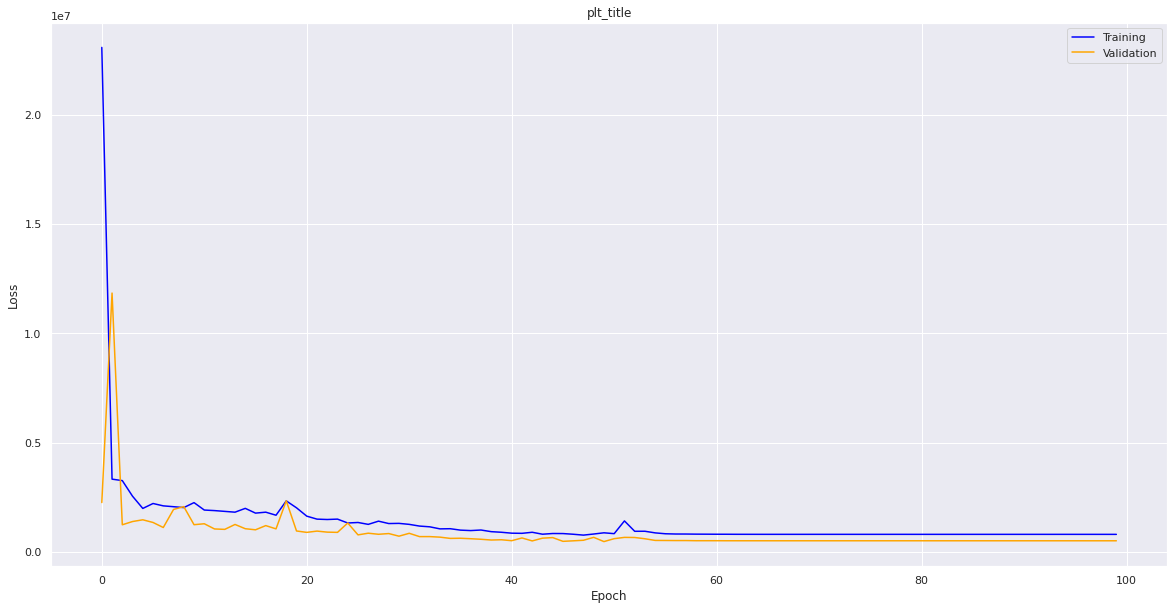

In [17]:
# Plot training Process 

plt.plot(history.history['loss'], label='Training', color = 'blue')
plt.plot(history.history['val_loss'], label='Validation', color = 'orange')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("plt_title")
plt.legend()
plt.show()

### Prediction Evaluation

In [18]:
# Create the predictions data frame
yhat_stacked = pd.DataFrame(np.reshape(np.array(stacked_LSTM.predict(X_test, verbose=0)), (7,1))) 

yhat_stacked.columns = ['predictions']

In [19]:
# Create the test set data frame
y_test = pd.DataFrame(np.reshape(np.array(y_test), (7,1)))

y_test.columns = ['real']

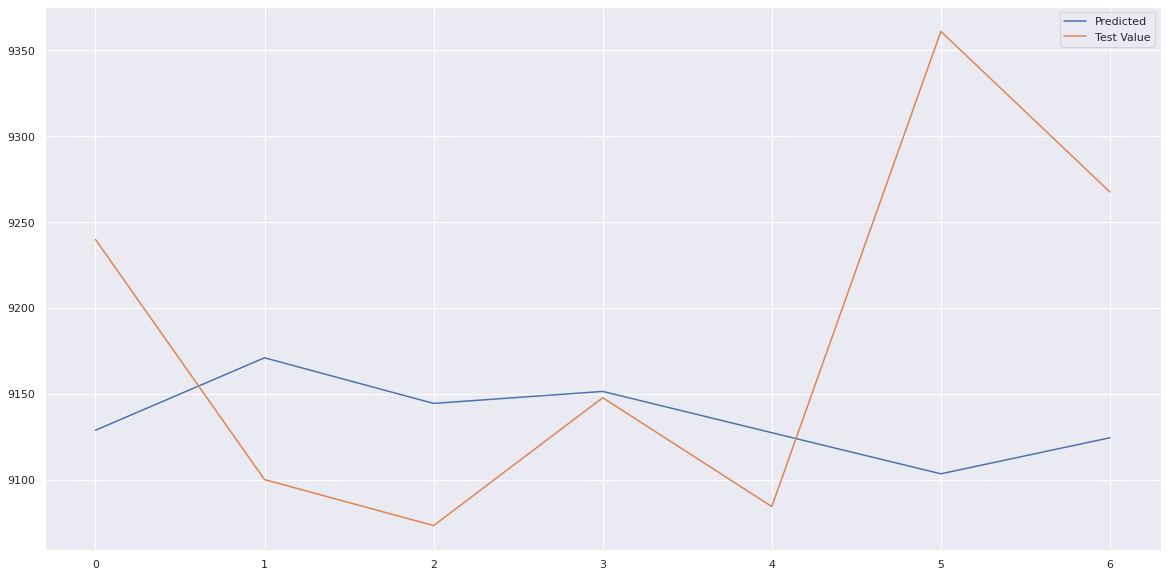

In [20]:
# Plot the predictions against the truth
plt.plot(yhat_stacked.index, yhat_stacked.predictions, label='Predicted')
plt.plot(y_test.index, y_test.real,label='Test Value')
plt.legend()
plt.show()


In [21]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(yhat_stacked.predictions, y_test.real)

rmse_val

126.06206810637185

# Enconder Decoder Univariate Multistep LSTM


# Model

In [23]:
# univariate multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [30]:
#Define the same modelling procure as the multi-step univariate LSTM, but include the RepeatVector function between each LSTM layer
# define model
ED_LSTM = Sequential()
ED_LSTM.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
ED_LSTM.add(RepeatVector(n_steps_out))
ED_LSTM.add(LSTM(50, activation='relu', return_sequences=True))
ED_LSTM.add(TimeDistributed(Dense(1)))
#model.compile(optimizer='adam', loss='mse')

In [31]:
#Set Callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Use early stopping, change patience as required
early_stopping = EarlyStopping(monitor='val_loss', patience=50,verbose=1)
# Use reduce LR, change patience and factor as required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)


learning_rate = 0.01
optimizer = optimizers.Adam(learning_rate = learning_rate)


ED_LSTM.compile(optimizer=optimizer, loss='mse')

In [32]:
# fit model
#model.fit(X_train, y_train, epochs=100, validation_split=0.2)

from time import time
import time
# Fit model
tic = time.perf_counter()

#model.fit(X_train, y_train, epochs=100, validation_split=0.2) #VALIDATION SPLIT???



# Change epochs as necessary
history = ED_LSTM.fit(
    X_train,
    y_train, 
    epochs=200,
    validation_split=0.2,
    callbacks = [early_stopping, reduce_lr])



toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model ran in: {run_time:0.2f} minutes')

Epoch 1/200
28/28 [==============================] - 1s 23ms/step - loss: 25581918.0000 - val_loss: 10190101.0000
Epoch 2/200
28/28 [==============================] - 0s 13ms/step - loss: 7291146.5000 - val_loss: 4114747.7500
Epoch 3/200
28/28 [==============================] - 0s 12ms/step - loss: 2599482.2500 - val_loss: 1430761.3750
Epoch 4/200
28/28 [==============================] - 0s 12ms/step - loss: 1093383.7500 - val_loss: 536681.1875
Epoch 5/200
28/28 [==============================] - 0s 13ms/step - loss: 742417.7500 - val_loss: 442466.1250
Epoch 6/200
28/28 [==============================] - 0s 14ms/step - loss: 707177.6875 - val_loss: 420182.4688
Epoch 7/200
28/28 [==============================] - 0s 13ms/step - loss: 690039.8750 - val_loss: 470008.1562
Epoch 8/200
28/28 [==============================] - 0s 12ms/step - loss: 693502.6875 - val_loss: 413035.3750
Epoch 9/200
28/28 [==============================] - 0s 12ms/step - loss: 696494.5625 - val_loss: 411583.9375
E

## Model Evaluation

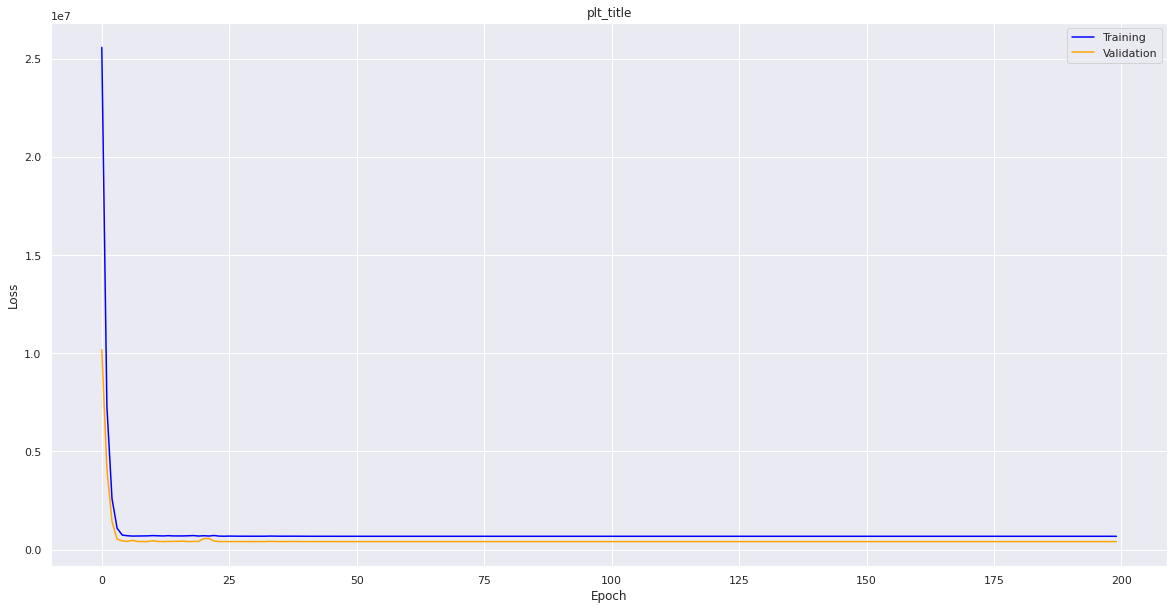

In [33]:
# Plot training Process 

plt.plot(history.history['loss'], label='Training', color = 'blue')
plt.plot(history.history['val_loss'], label='Validation', color = 'orange')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("plt_title")
plt.legend()
plt.show()

## Prediction Evaluation

In [36]:
# Create the predictions data frame
yhat_ED = pd.DataFrame(np.reshape(np.array(ED_LSTM.predict(X_test, verbose=0)), (7,1)))

yhat_ED.columns = ['predictions']

In [37]:
# Create the test set data frame
y_test = pd.DataFrame(np.reshape(np.array(y_test), (7,1)))

y_test.columns = ['real']

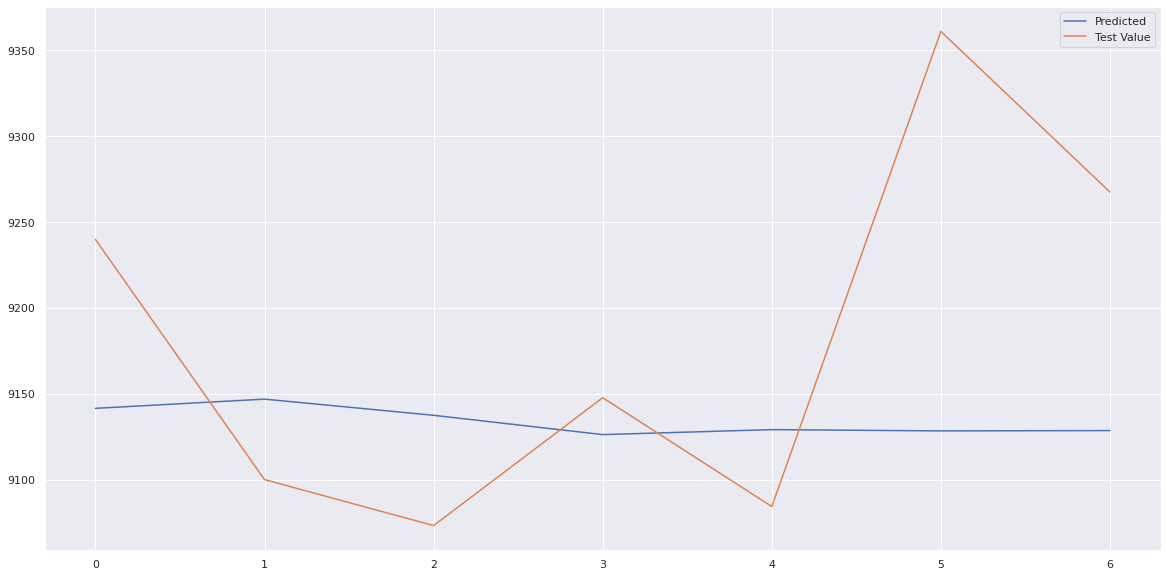

In [38]:
# Plot the predictions against the truth

plt.plot(yhat_ED.index, yhat_ED.predictions, label='Predicted')
plt.plot(y_test.index, y_test.real,label='Test Value')
plt.legend()
plt.show()

In [39]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(yhat_ED.predictions, y_test.real)

rmse_val

114.61530226000663

# CNN LSTM

In [40]:
# univariate cnn lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [41]:
# define input sequence for TRAIN
train_seq = train
# choose a number of time steps
n_steps_in, n_steps_out = 14, 7

# split into samples
X_train, y_train = split_sequence(train_seq, n_steps_in, n_steps_out)



# SAME CODE AS BEFORE FOR TEST 
# define input sequence for TEST
test_seq = test
# choose a number of time steps
n_steps_in, n_steps_out = 14, 7
# split into samples
X_test, y_test = split_sequence(test_seq, n_steps_in, n_steps_out)
# summarize the data


In [42]:
# NEW CODE FOR CNN LSTM
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2    #2 Subsambples
n_steps = 7  # 2 subsamples of 7 steps 

X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))

In [43]:
# define model
CNN_LSTM = Sequential()
CNN_LSTM.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features))) # n_steps_in, n_features
CNN_LSTM.add(TimeDistributed(MaxPooling1D(pool_size=2)))
CNN_LSTM.add(TimeDistributed(Flatten()))
CNN_LSTM.add(LSTM(50, activation='relu'))
CNN_LSTM.add(Dense(n_steps_out)) #Multistep  previosly =  (1)
#model.compile(optimizer='adam', loss='mse')

In [44]:
#Set Callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras import optimizers

# Use early stopping, change patience as required
early_stopping = EarlyStopping(monitor='val_loss', patience=50,verbose=1)
# Use reduce LR, change patience and factor as required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)


learning_rate = 0.01
optimizer = optimizers.Adam(learning_rate = learning_rate)


CNN_LSTM.compile(optimizer=optimizer, loss='mse')

In [45]:
# fit model
#model.fit(X_train, y_train, epochs=100, validation_split=0.2)


from time import time
import time
# Fit model
tic = time.perf_counter()

#model.fit(X_train, y_train, epochs=100, validation_split=0.2) #VALIDATION SPLIT???



# Change epochs as necessary
history = CNN_LSTM.fit(
    X_train,
    y_train, 
    epochs=100,
    validation_split=0.2,
    callbacks = [early_stopping, reduce_lr])



toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model ran in: {run_time:0.2f} minutes')


Epoch 1/100
28/28 [==============================] - 0s 12ms/step - loss: 11883525.0000 - val_loss: 1414231.1250
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 1502322.8750 - val_loss: 809312.3125
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 1299465.7500 - val_loss: 787181.5625
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 1283776.0000 - val_loss: 716106.9375
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 1211664.6250 - val_loss: 745330.6250
Epoch 6/100
28/28 [==============================] - 0s 4ms/step - loss: 1219086.3750 - val_loss: 672917.3750
Epoch 7/100
28/28 [==============================] - 0s 4ms/step - loss: 1113779.1250 - val_loss: 694722.8750
Epoch 8/100
28/28 [==============================] - 0s 4ms/step - loss: 1131545.5000 - val_loss: 740002.0000
Epoch 9/100
28/28 [==============================] - 0s 4ms/step - loss: 1087471.7500 - val_loss: 859631.8125
Epoch 1

### Model Evaluation

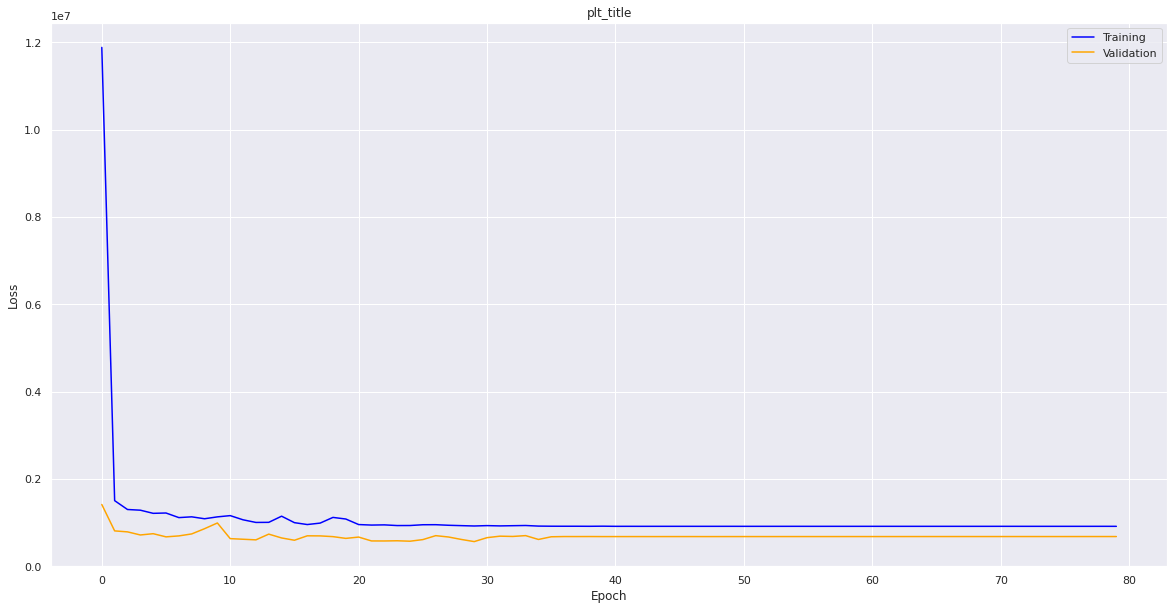

In [46]:
# Plot training Process 

plt.plot(history.history['loss'], label='Training', color = 'blue')
plt.plot(history.history['val_loss'], label='Validation', color = 'orange')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("plt_title")
plt.legend()
plt.show()

### Prediction Evaluation

In [47]:
#Get X test into the right shape
X_test=X_test.reshape((1, n_seq, n_steps, n_features))

#Precidt
yhat_CNN_LSTM = CNN_LSTM.predict(X_test, verbose=0)

In [ ]:
# Create the predictions data frame


#yhat = model.predict(X_test, verbose=0)

#yhat = pd.DataFrame(np.reshape(np.array(model.predict(X_test, verbose=0)), (2, 7, 1)))
#yhat.columns = ['predictions']




#Stacked
# # fit model
# model.fit(X, y, epochs=200, verbose=0)
# # demonstrate prediction
# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)


#CNN
# ## fit model
# model.fit(X, y, epochs=500, verbose=0)
# # demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

#Multistep
# # fit model
# model.fit(X, y, epochs=50, verbose=0)
# # demonstrate prediction
# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

#mio
# # Create the predictions data frame
# yhat = pd.DataFrame(np.reshape(np.array(model.predict(X_test, verbose=0)), (7,1)))

# yhat.columns = ['predictions']

In [48]:
#Tranform the predictions into a Df
yhat_CNN_LSTM = pd.DataFrame(yhat_CNN_LSTM)

In [49]:
#Reshape the DF 
yhat_CNN_LSTM = yhat_CNN_LSTM.T
yhat_CNN_LSTM.columns = ['predictions']

In [50]:
# Create the test set data frame
y_test = pd.DataFrame(np.reshape(np.array(y_test), (7,1)))

y_test.columns = ['real']

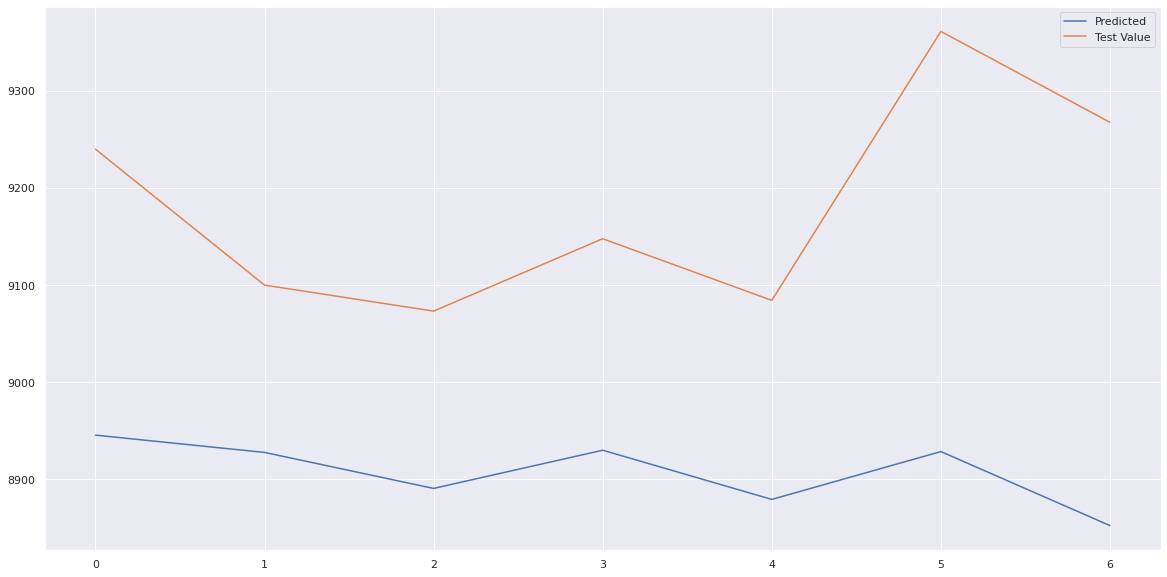

In [51]:
# Plot the predictions against the truth

plt.plot(yhat_CNN_LSTM.index, yhat_CNN_LSTM.predictions, label='Predicted')
plt.plot(y_test.index, y_test.real,label='Test Value')
plt.legend()
plt.show()

In [52]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(yhat_CNN_LSTM.predictions, y_test.real)

rmse_val

292.34039754317723

# Model Comparisson

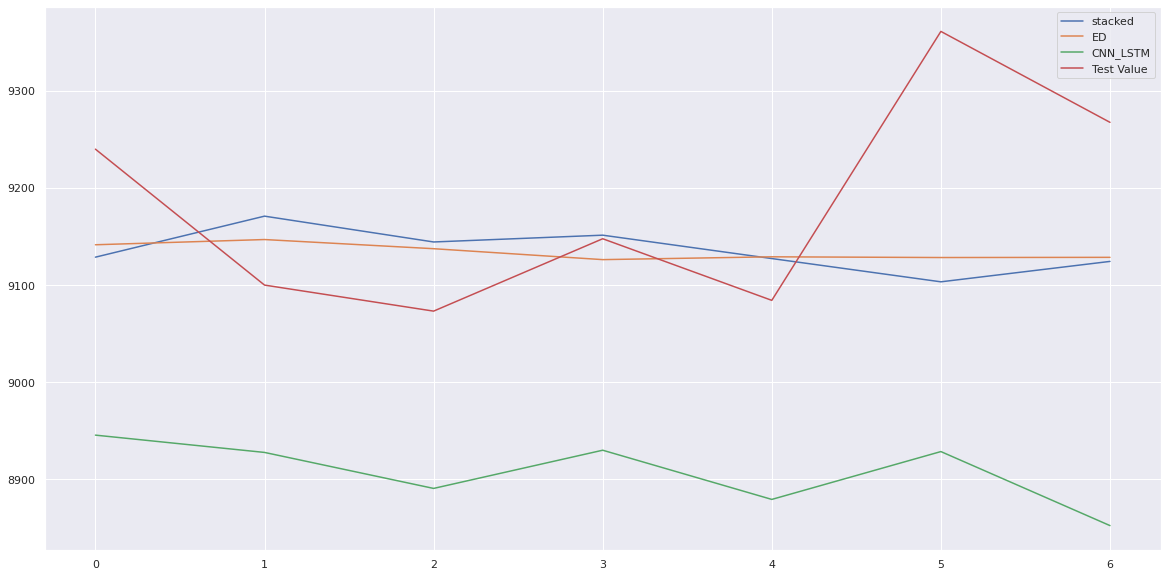

In [53]:
plt.plot(yhat_stacked.index, yhat_stacked.predictions, label='stacked')
plt.plot(yhat_ED.index, yhat_ED.predictions, label='ED')
plt.plot(yhat_CNN_LSTM.index, yhat_CNN_LSTM.predictions, label='CNN_LSTM')
plt.plot(y_test.index, y_test.real,label='Test Value')
plt.legend()
plt.show()

#Multivariate Multi-Step LSTM

## Data Partitioning 

In [54]:
data = daily_data[["BTC_close","ETHER_close", "XRP_close" ]]

In [55]:
data

,BTC_close,ETHER_close,XRP_close
0,1966.500000,124.40,0.32498
1,2059.300000,123.03,0.34716
2,2026.600000,146.14,0.32700
3,2087.300000,154.92,0.29717
4,2249.600000,168.24,0.32158
...,...,...,...
1169,11350.000000,346.82,0.25983
1170,11804.744013,387.15,0.29103
1171,11053.772562,371.87,0.28764
1172,11226.521728,385.68,0.30974


In [56]:
# remove first obsrvations to start the data set in the first Monday (2017-05-22 00:00:00+00:00)
# End the data set in the last Sunday (2020-08-02 00:00:00+00:00)

data = data[3:1172] #Subset for exact weeks 
data.index = np.arange(len(data)) #restart index in 0
data

,BTC_close,ETHER_close,XRP_close
0,2087.300000,154.920000,0.29717
1,2249.600000,168.240000,0.32158
2,2395.500000,183.880000,0.28860
3,2268.100000,168.710000,0.23820
4,2125.900000,152.800000,0.25900
...,...,...,...
1164,11117.000000,318.460000,0.24370
1165,11123.000000,335.428724,0.24462
1166,11350.000000,346.820000,0.25983
1167,11804.744013,387.150000,0.29103


In [57]:
#Check the sacle for values 
print("Min:", np.min(data))
print("Max:", np.max(data))

Min: BTC_close      1925.0000
ETHER_close      85.1980
XRP_close         0.1374
dtype: float64
Max: BTC_close      19210.0000
ETHER_close     1379.9000
XRP_close          2.7665
dtype: float64


In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler(feature_range=(-1,1))

#scaler = StandardScaler()

data = scaler.fit_transform(data)
data = pd.DataFrame(data)
data.columns = ['BTC_close','ETHER_close', 'XRP_close']
data

,BTC_close,ETHER_close,XRP_close
0,-0.981221,-0.892296,-0.878460
1,-0.962441,-0.871720,-0.859891
2,-0.945560,-0.847560,-0.884980
3,-0.960301,-0.870994,-0.923320
4,-0.976754,-0.895571,-0.907497
...,...,...,...
1164,0.063581,-0.639667,-0.919136
1165,0.064275,-0.613454,-0.918436
1166,0.090541,-0.595858,-0.906865
1167,0.143158,-0.533558,-0.883131


In [59]:
#Check the sacle for values 
print("Min:", np.min(data))
print("Max:", np.max(data))

Min: BTC_close     -1.0
ETHER_close   -1.0
XRP_close     -1.0
dtype: float64
Max: BTC_close      1.0
ETHER_close    1.0
XRP_close      1.0
dtype: float64


In [60]:
# We will train on first 1153 and test on last 28 days, ie, 14 steps in and 14 steps out
# Look back into past 14 days and predict 14 days ahead
# train = data[0:1140]
# test = data[1141:1169]

# Look back into past 14 days and predict 7 days ahead
# train = data[0:1147]
# test = data[1148:1169]

# # Partition for May (test on the last week of april and first of may)
# train = data[0:1153]
# test = data[1054:1082]


# Partition for July (test on last week of June and first of July)
# train = data[0:1114]
# test = data[1115:1143]

# 14 In 7 Out
# Partition for July (test on last week of June and first of July)
train = data[0:1121]
test = data[1122:1143]


#Check number of observations
print(len(train))
print(len(test))

1121
21


## Reshape and split

In [61]:
## Parallel
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:int(end_ix), :], sequences[int(end_ix):int(out_end_ix), :] #changed to integers
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [62]:
# Reshape TRain data 
# define input sequence
train_in_seq1 = np.array(train.BTC_close)
train_in_seq2 = np.array(train.ETHER_close)
train_out_seq = np.array(train.XRP_close)


# convert to [rows, columns] structure
train_in_seq1 = train_in_seq1.reshape((len(train_in_seq1), 1))
train_in_seq2 = train_in_seq2.reshape((len(train_in_seq2), 1))
train_out_seq = train_out_seq.reshape((len(train_out_seq), 1))


from numpy import hstack
# horizontally stack columns
train_dataset = hstack((train_in_seq1, train_in_seq2, train_out_seq))

# choose a number of time steps
n_steps_in, n_steps_out = 14, 7   #14, 14
# covert into input/output
X_train, y_train = split_sequences(train_dataset, n_steps_in, n_steps_out)

print(X_train.shape, y_train.shape)
#number of samples, time steps, and variables

(1101, 14, 3) (1101, 7, 3)


In [63]:
# summarize the data
#for i in range(len(X_train)):
#	print(X_train[i], y_train[i])

In [64]:
# Reshape TEST data 
# define input sequence
test_in_seq1 = np.array(test.BTC_close)
test_in_seq2 = np.array(test.ETHER_close)
test_out_seq = np.array(test.XRP_close)


# convert to [rows, columns] structure
test_in_seq1 = test_in_seq1.reshape((len(test_in_seq1), 1))
test_in_seq2 = test_in_seq2.reshape((len(test_in_seq2), 1))
test_out_seq = test_out_seq.reshape((len(test_out_seq), 1))


from numpy import hstack
# horizontally stack columns
test_dataset = hstack((test_in_seq1, test_in_seq2, test_out_seq))

# choose a number of time steps
n_steps_in, n_steps_out = 14,7 #14, 14
# covert into input/output
X_test, y_test = split_sequences(test_dataset, n_steps_in, n_steps_out)

print(X_test.shape, y_test.shape)
#number of samples, time steps, and variables

(1, 14, 3) (1, 7, 3)


## Endoder Decoder LSTM

In [65]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [66]:
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]


# define model
Paralell_ED = Sequential()
Paralell_ED.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
Paralell_ED.add(RepeatVector(n_steps_out))
Paralell_ED.add(LSTM(50, activation='relu', return_sequences=True))
Paralell_ED.add(TimeDistributed(Dense(n_features)))
#model.compile(optimizer='adam', loss='mse')

In [67]:
#Set Callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras import optimizers

# Use early stopping, change patience as required
early_stopping = EarlyStopping(monitor='val_loss', patience=50,verbose=1)
# Use reduce LR, change patience and factor as required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0000001, verbose=1)


learning_rate = 0.01
optimizer = optimizers.Adam(learning_rate = learning_rate)


Paralell_ED.compile(optimizer=optimizer, loss='mse')

In [68]:
# fit model

from time import time
import time
# Fit model
tic = time.perf_counter()

# Change epochs as necessary
history = Paralell_ED.fit(
    X_train,
    y_train, 
    epochs=150,
    validation_split=0.2, #batch_size = 32,
    callbacks = [early_stopping, reduce_lr])

toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model ran in: {run_time:0.2f} minutes')

Epoch 1/150
28/28 [==============================] - 1s 24ms/step - loss: 0.1338 - val_loss: 0.0305
Epoch 2/150
28/28 [==============================] - 0s 11ms/step - loss: 0.0209 - val_loss: 0.0077
Epoch 3/150
28/28 [==============================] - 0s 11ms/step - loss: 0.0111 - val_loss: 0.0045
Epoch 4/150
28/28 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0036
Epoch 5/150
28/28 [==============================] - 0s 13ms/step - loss: 0.0080 - val_loss: 0.0067
Epoch 6/150
28/28 [==============================] - 0s 13ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 7/150
28/28 [==============================] - 0s 13ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 8/150
28/28 [==============================] - 0s 12ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 9/150
28/28 [==============================] - 0s 12ms/step - loss: 0.0057 - val_loss: 0.0065
Epoch 10/150
28/28 [==============================] - 0s 12ms/step - loss: 0.0055 - val_loss: 0.0037

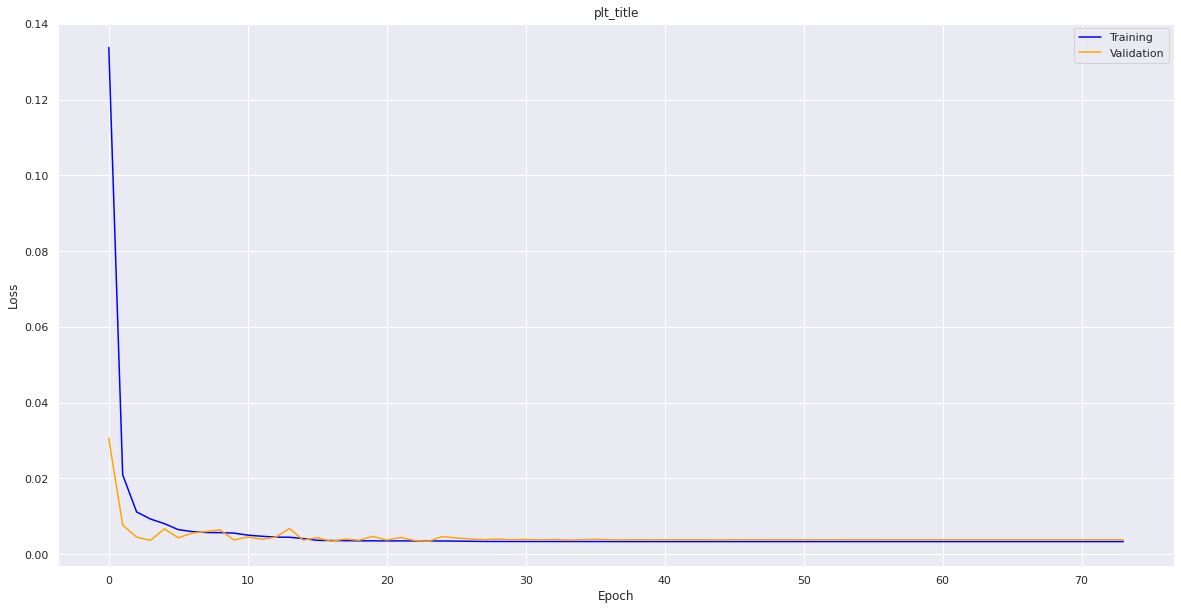

In [69]:
# Plot training Process 

plt.plot(history.history['loss'], label='Training', color = 'blue')
plt.plot(history.history['val_loss'], label='Validation', color = 'orange')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("plt_title")
plt.legend()
plt.show()

### Predict

In [ ]:
# # demonstrate prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [70]:
# Create the predictions data frame
yhat_parallel = pd.DataFrame(np.reshape(np.array(Paralell_ED.predict(X_test, verbose=0)), (n_steps_out,n_features)))

In [71]:
yhat_parallel

,0,1,2
0,-0.090456,-0.795931,-0.958859
1,-0.091232,-0.787272,-0.930893
2,-0.082403,-0.795203,-0.938311
3,-0.074499,-0.791917,-0.935482
4,-0.070949,-0.790478,-0.933364
5,-0.070002,-0.789033,-0.930594
6,-0.070579,-0.787993,-0.928126


In [72]:
yhat_parallel = scaler.inverse_transform(yhat_parallel)
yhat_parallel = pd.DataFrame(yhat_parallel)

In [73]:
yhat_parallel.columns = ['BTC_predictions', 'ETHER_predictions', 'XRP_predictions']
yhat_parallel

,BTC_predictions,ETHER_predictions,XRP_predictions
0,9785.735352,217.302368,0.191482
1,9779.028320,222.907547,0.228245
2,9855.328125,217.773407,0.218493
3,9923.640625,219.901001,0.222213
4,9954.327148,220.832138,0.224996
5,9962.506836,221.767395,0.228637
6,9957.517578,222.440857,0.231882


In [74]:
# Create the test set data frame
y_test = pd.DataFrame(np.reshape(np.array(y_test), (n_steps_out,n_features)))

In [75]:
y_test

,0,1,2
0,-0.153613,-0.774293,-0.970134
1,-0.169800,-0.781616,-0.971450
2,-0.172901,-0.783530,-0.970210
3,-0.164281,-0.776934,-0.968856
4,-0.171619,-0.779498,-0.969609
5,-0.139589,-0.757578,-0.960762
6,-0.150418,-0.761439,-0.963463


In [76]:
y_test = scaler.inverse_transform(y_test)
y_test = pd.DataFrame(y_test)


In [77]:
y_test.columns = ['BTC_test', 'ETHER_test','XRP_test' ]
y_test

,BTC_test,ETHER_test,XRP_test
0,9239.900000,231.309557,0.17666
1,9100.000000,226.568972,0.17493
2,9073.200000,225.330000,0.17656
3,9147.700000,229.600000,0.17834
4,9084.284734,227.940000,0.17735
5,9361.100000,242.130000,0.18898
6,9267.514949,239.630557,0.18543


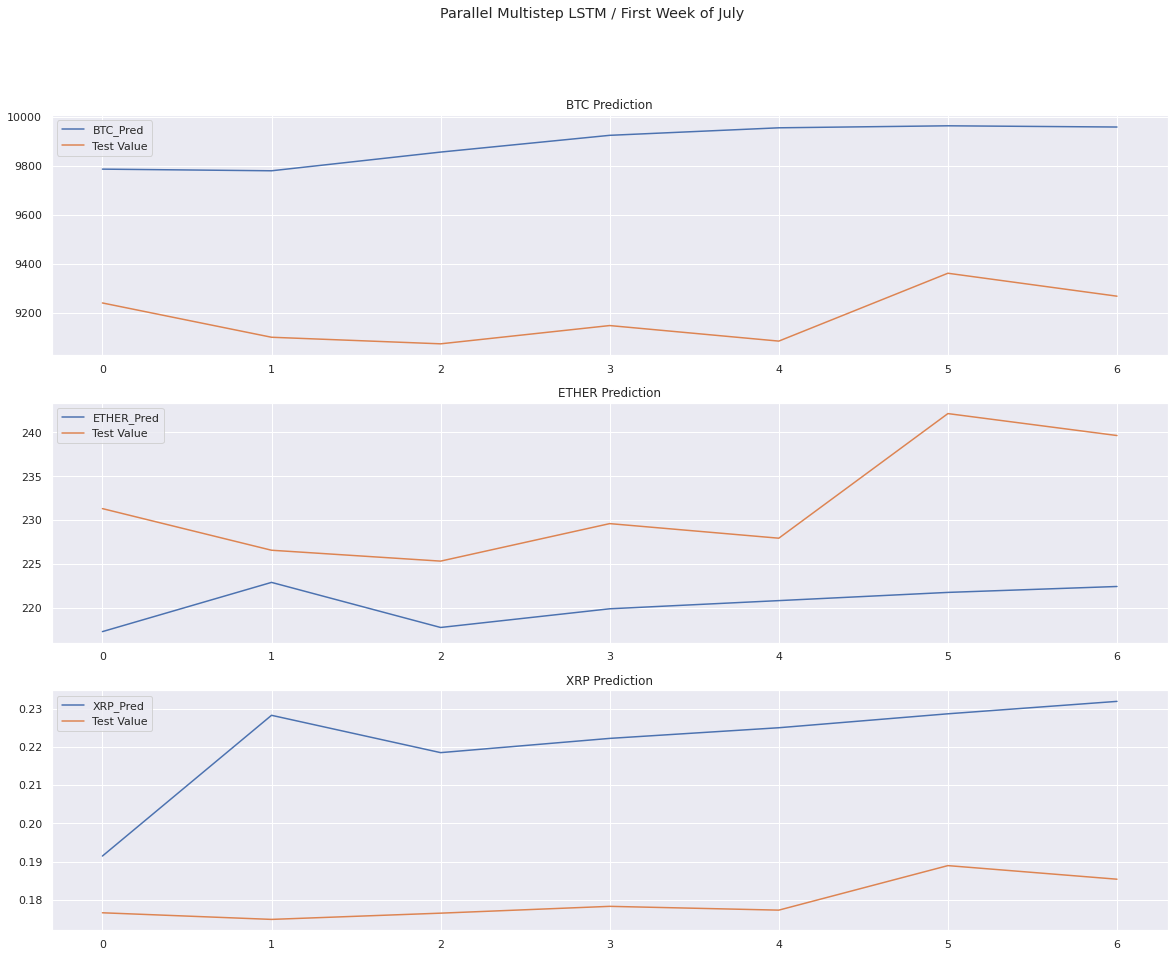

In [80]:

fig, axs = plt.subplots(3, 1, figsize=(20,15))
plt.suptitle("Parallel Multistep LSTM / First Week of July")

axs[0].plot(yhat_parallel.index, yhat_parallel.BTC_predictions ,label='BTC_Pred')
axs[0].plot(y_test.index, y_test.BTC_test ,label='Test Value') #
axs[0].set_title('BTC Prediction')
axs[0].legend()

axs[1].plot(yhat_parallel.index,  yhat_parallel.ETHER_predictions,label='ETHER_Pred')
axs[1].plot(y_test.index, y_test.ETHER_test ,label='Test Value') 
axs[1].set_title('ETHER Prediction')
axs[1].legend()

axs[2].plot(yhat_parallel.index,  yhat_parallel.XRP_predictions,label='XRP_Pred')
axs[2].plot(y_test.index, y_test.XRP_test ,label='Test Value') 
axs[2].set_title('XRP Prediction')
axs[2].legend()


plt.legend()
plt.show()

In [81]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val_btc = rmse(yhat_parallel.BTC_predictions, y_test.BTC_test)

rmse_val_eth = rmse(yhat_parallel.ETHER_predictions, y_test.ETHER_test)

rmse_val_xrp = rmse(yhat_parallel.XRP_predictions, y_test.XRP_test)


print(rmse_val_btc)

print(rmse_val_eth)

print(rmse_val_xrp)

713.9019101662137
12.657144925455047
0.04267131281547918


# Multivariate multistep BTC
(NOT COMPLETED)


for some resason he predictiopns are 2 columns when it should be only 1


## Data Partitioning 

In [ ]:
data = daily_data

In [ ]:
# Subset to only bitcoin close and vol
data = data[["BTC_close","BTC_vol", "ETHER_vol" ]]#data[["BTC_close","BTC_vol" ]]

In [ ]:
data

,BTC_close,BTC_vol,ETHER_vol
0,1966.500000,23001.542773,257956.362939
1,2059.300000,21690.022393,122882.371427
2,2026.600000,17221.878675,220184.308469
3,2087.300000,57231.824243,473706.454399
4,2249.600000,22521.559138,144988.858583
...,...,...,...
1169,11350.000000,5830.145883,145813.101733
1170,11804.744013,10574.542594,214176.492612
1171,11053.772562,13217.636459,322415.937958
1172,11226.521728,4085.500508,126895.684080


In [ ]:
# Duplicate the bitcoin close 
#data['BTC_close_X'] = data['BTC_close'] 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# lagg bitcoion close and vol (one day, because we dont have that information yet)
#data['BTC_close_X'] = data['BTC_close_X'].shift(1)
data['ETHER_vol'] = data['ETHER_vol'].shift(1)
data['BTC_vol'] = data['BTC_vol'].shift(1)
data.dropna(inplace=True) #drop NA
data.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

In [ ]:
data = data[["ETHER_vol","BTC_vol", "BTC_close" ]]#data[["BTC_close_X","BTC_vol", "BTC_close" ]]
data

,ETHER_vol,BTC_vol,BTC_close
0,257956.362939,23001.542773,2059.300000
1,122882.371427,21690.022393,2026.600000
2,220184.308469,17221.878675,2087.300000
3,473706.454399,57231.824243,2249.600000
4,144988.858583,22521.559138,2395.500000
...,...,...,...
1168,89569.975403,4250.910082,11350.000000
1169,145813.101733,5830.145883,11804.744013
1170,214176.492612,10574.542594,11053.772562
1171,322415.937958,13217.636459,11226.521728


In [ ]:
# remove first obsrvations to start the data set in the first Monday (2017-05-22 00:00:00+00:00) BTC_Close = 2087.300000
# End the data set in the last Sunday (2020-08-02 00:00:00+00:00) BTC_close = 11053.772562

data = data[3:1172] #Subset for exact weeks 
data.index = np.arange(len(data)) #restart index in 0
data

,ETHER_vol,BTC_vol,BTC_close
0,473706.454399,57231.824243,2249.600000
1,144988.858583,22521.559138,2395.500000
2,184596.677902,29620.827843,2268.100000
3,246730.476672,55075.881722,2125.900000
4,186150.536179,39694.888253,1980.200000
...,...,...,...
1164,118426.367772,8822.499030,11123.000000
1165,89569.975403,4250.910082,11350.000000
1166,145813.101733,5830.145883,11804.744013
1167,214176.492612,10574.542594,11053.772562


## Data Partitioning

In [ ]:
len(data)

1169

In [ ]:
#data[1141:1169]

In [ ]:
# We will train on first 1153 and test on last 28 days, ie, 14 steps in and 14 steps out
# Look back into past 14 days and predict 14 days ahead
# train = data[0:1140]
# test = data[1141:1169]

# Look back into past 14 days and predict 7 days ahead
# train = data[0:1147]
# test = data[1148:1169]

# # Partition for May (test on the last week of april and first of may)
# train = data[0:1153]
# test = data[1054:1082]


# Partition for July (test on last week of June and first of July)
# train = data[0:1114]
# test = data[1115:1143]

# 14 In 7 Out
# Partition for July (test on last week of June and first of July)
train = data[0:1121]
test = data[1122:1143]


#Check number of observations
print(len(train))
print(len(test))

1121
21


## Data tranformation

In [ ]:

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1. #MINUS 1?
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:int(end_ix), :-1], sequences[int(end_ix)-1:int(out_end_ix), -1]
		#seq_x, seq_y = sequences[i:int(end_ix), :], sequences[int(end_ix):int(out_end_ix), :] #changed to integers
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
#Train data set 
# define input sequence
#train_Inseq1 = np.array(train.BTC_close_X)
train_Inseq1 = np.array(train.ETHER_vol)
train_Inseq2 = np.array(train.BTC_vol)

## Reshape 
# convert to [rows, columns] structure
train_Inseq1 = train_Inseq1.reshape((len(train_Inseq1), 1))
train_Inseq2 = train_Inseq2.reshape((len(train_Inseq2), 1))


#out seq
train_Outseq = np.array(train.BTC_close)
#Reshape
train_Outseq = train_Outseq.reshape((len(train_Outseq), 1))

In [ ]:
# horizontally stack columns
from numpy import hstack
dataset = hstack((train_Inseq1, train_Inseq2, train_Outseq))

In [ ]:
dataset

array([[473706.45439874,  57231.82424294,   2249.6       ],
       [144988.85858293,  22521.55913805,   2395.5       ],
       [184596.67790197,  29620.82784304,   2268.1       ],
       ...,
       [ 37194.55847502,   1845.56355902,   9344.75144536],
       [ 76640.48410652,   2698.82455588,   9435.        ],
       [106435.38659887,  10162.01504916,   9534.401723  ]])

In [ ]:
from numpy import array
# horizontally stack columns
#dataset = hstack((train_Inseq1, train_Inseq2, train_Outseq))
# choose a number of time steps
n_steps_in, n_steps_out = 14, 7
# covert into input/output
X_train, y_train = split_sequences(dataset, n_steps_in, n_steps_out)
print(X_train.shape, y_train.shape)


(1102, 14, 2) (1102, 7)


In [ ]:
# summarize the data
#for i in range(len(X_train)):
# 	print(X_train[i], y_train[i])

We can see that the shape of the input portion of the samples is three-dimensional, comprised of 1114 samples, with 14 time steps, and 2 variables for the 2 input time series.

The output portion of the samples is two-dimensional for the 1114 samples and the 14 time steps for each sample to be predicted

In [ ]:
# #test data set 
# define input sequence
#test_Inseq1 = np.array(test.BTC_close_X)
test_Inseq1 = np.array(test.ETHER_vol)
test_Inseq2 = np.array(test.BTC_vol)

## Reshape 
# convert to [rows, columns] structure
test_Inseq1 = test_Inseq1.reshape((len(test_Inseq1), 1))
test_Inseq2 = test_Inseq2.reshape((len(test_Inseq2), 1))


#out seq
test_Outseq = np.array(test.BTC_close)
#Reshape
test_Outseq = test_Outseq.reshape((len(test_Outseq), 1))


from numpy import hstack
# horizontally stack columns
test_dataset = hstack((test_Inseq1, test_Inseq2, test_Outseq))

# choose a number of time steps
n_steps_in, n_steps_out = 14,7 #14, 14
# covert into input/output
X_test, y_test = split_sequences(test_dataset, n_steps_in, n_steps_out)

print(X_test.shape, y_test.shape)
#number of samples, time steps, and variables

(2, 14, 2) (2, 7)


In [ ]:
data[1122:1143]

,ETHER_vol,BTC_vol,BTC_close
1122,53585.320476,3140.719512,9400.000000
1123,19576.409479,1658.234920,9315.500000
1124,29108.922547,2615.700830,9371.300000
1125,27012.556140,1858.011062,9301.000000
1126,23255.624871,1338.642110,9697.728165
1127,123882.180744,5876.938156,9635.200000
1128,46493.788777,3420.818742,9312.100000
1129,90926.072625,5524.842927,9257.034669
1130,54495.200452,5545.253350,9173.100000
1131,34442.620990,3690.819849,9015.300000


In [ ]:
# summarize the data
for i in range(len(X_test)):
 	print(X_test[i], y_test[i])

[[ 53585.32047613   3140.71951161]
 [ 19576.40947943   1658.23492008]
 [ 29108.92254729   2615.7008299 ]
 [ 27012.55613965   1858.01106203]
 [ 23255.62487055   1338.64211008]
 [123882.18074423   5876.93815576]
 [ 46493.78877707   3420.81874169]
 [ 90926.07262493   5524.84292725]
 [ 54495.20045186   5545.25335034]
 [ 34442.62099017   3690.81984869]
 [ 56774.99387326   3371.5346703 ]
 [ 37340.47022513   2110.23642108]
 [ 30406.99911835   3642.39903593]
 [ 16351.38981932   1832.60791706]] [9239.9        9100.         9073.2        9147.7        9084.28473392
 9361.1        9267.51494932]
[[ 19576.40947943   1658.23492008]
 [ 29108.92254729   2615.7008299 ]
 [ 27012.55613965   1858.01106203]
 [ 23255.62487055   1338.64211008]
 [123882.18074423   5876.93815576]
 [ 46493.78877707   3420.81874169]
 [ 90926.07262493   5524.84292725]
 [ 54495.20045186   5545.25335034]
 [ 34442.62099017   3690.81984869]
 [ 56774.99387326   3371.5346703 ]
 [ 37340.47022513   2110.23642108]
 [ 30406.99911835   364

In [ ]:
X_test

array([[[ 53585.32047613,   3140.71951161],
        [ 19576.40947943,   1658.23492008],
        [ 29108.92254729,   2615.7008299 ],
        [ 27012.55613965,   1858.01106203],
        [ 23255.62487055,   1338.64211008],
        [123882.18074423,   5876.93815576],
        [ 46493.78877707,   3420.81874169],
        [ 90926.07262493,   5524.84292725],
        [ 54495.20045186,   5545.25335034],
        [ 34442.62099017,   3690.81984869],
        [ 56774.99387326,   3371.5346703 ],
        [ 37340.47022513,   2110.23642108],
        [ 30406.99911835,   3642.39903593],
        [ 16351.38981932,   1832.60791706]],

       [[ 19576.40947943,   1658.23492008],
        [ 29108.92254729,   2615.7008299 ],
        [ 27012.55613965,   1858.01106203],
        [ 23255.62487055,   1338.64211008],
        [123882.18074423,   5876.93815576],
        [ 46493.78877707,   3420.81874169],
        [ 90926.07262493,   5524.84292725],
        [ 54495.20045186,   5545.25335034],
        [ 34442.62099017,   36

In [ ]:
y_test

array([[9239.9       , 9100.        , 9073.2       , 9147.7       ,
        9084.28473392, 9361.1       , 9267.51494932],
       [9100.        , 9073.2       , 9147.7       , 9084.28473392,
        9361.1       , 9267.51494932, 9447.        ]])

## Endoder Decoder LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [ ]:
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]


# define model
multivariate_LSTM = Sequential()
multivariate_LSTM.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
multivariate_LSTM.add(LSTM(50, activation='relu'))
multivariate_LSTM.add(Dense(n_steps_out))
#model.compile(optimizer='adam', loss='mse')



#model.compile(optimizer='adam', loss='mse')

In [ ]:
#Set Callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras import optimizers

# Use early stopping, change patience as required
early_stopping = EarlyStopping(monitor='val_loss', patience=50,verbose=1)
# Use reduce LR, change patience and factor as required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0000001, verbose=1)


learning_rate = 0.01
optimizer = optimizers.Adam(learning_rate = learning_rate)


multivariate_LSTM.compile(optimizer=optimizer, loss='mse')

In [ ]:
# fit model

from time import time
import time
# Fit model
tic = time.perf_counter()

# Change epochs as necessary
history = multivariate_LSTM.fit(
    X_train,
    y_train, 
    epochs=150,
    validation_split=0.2, #batch_size = 32,
    callbacks = [early_stopping, reduce_lr])

toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model ran in: {run_time:0.2f} minutes')

Epoch 1/150
28/28 [==============================] - 1s 32ms/step - loss: 75041336.0000 - val_loss: 59524388.0000
Epoch 2/150
28/28 [==============================] - 1s 19ms/step - loss: 29982116.0000 - val_loss: 39198372.0000
Epoch 3/150
28/28 [==============================] - 1s 18ms/step - loss: 24255014.0000 - val_loss: 41202108.0000
Epoch 4/150
28/28 [==============================] - 0s 17ms/step - loss: 23662922.0000 - val_loss: 46086800.0000
Epoch 5/150
28/28 [==============================] - 1s 19ms/step - loss: 21243362.0000 - val_loss: 42718232.0000
Epoch 6/150
28/28 [==============================] - 1s 18ms/step - loss: 18567994.0000 - val_loss: 45769796.0000
Epoch 7/150
28/28 [==============================] - 1s 18ms/step - loss: 18240074.0000 - val_loss: 43274820.0000
Epoch 8/150
28/28 [==============================] - 1s 18ms/step - loss: 18033538.0000 - val_loss: 38723044.0000
Epoch 9/150
28/28 [==============================] - 1s 18ms/step - loss: 18190504.0000 

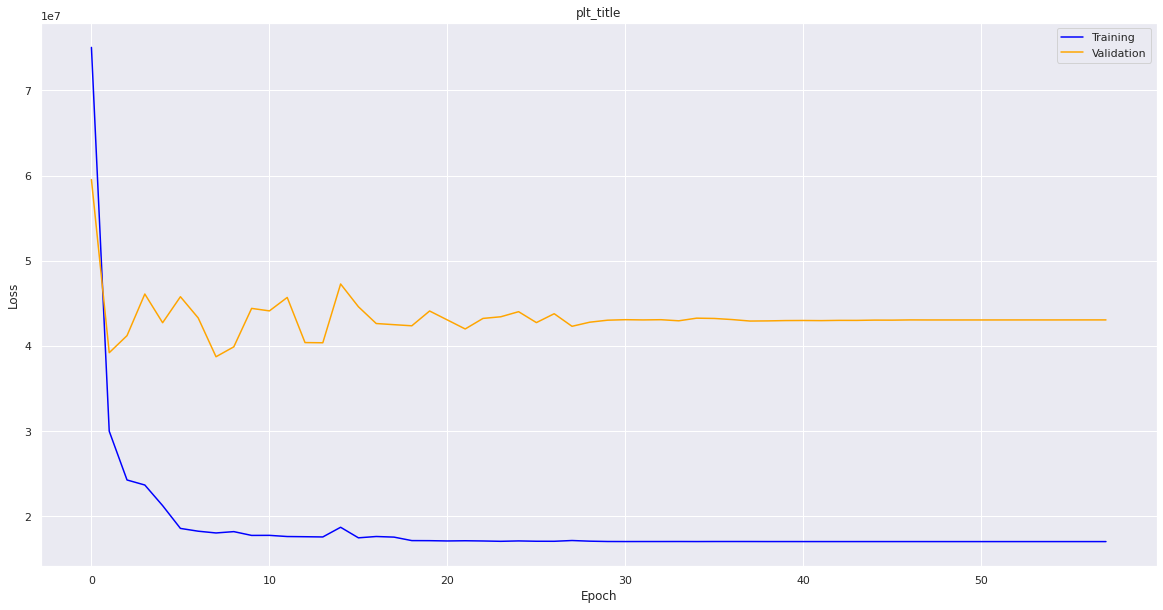

In [ ]:
# Plot training Process 

plt.plot(history.history['loss'], label='Training', color = 'blue')
plt.plot(history.history['val_loss'], label='Validation', color = 'orange')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("plt_title")
plt.legend()
plt.show()

### Predict

In [ ]:
# # demonstrate prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [ ]:
X_test = X_test.reshape((1, n_steps_out, n_features))
X_test

ValueError: ignored

In [ ]:
yhat_multistep = model.predict(X_test, verbose=0)

In [ ]:
# Create the predictions data frame
yhat_multistep = pd.DataFrame(np.reshape(np.array(multivariate_LSTM.predict(X_test, verbose=0)), (n_steps_out,n_features)))

In [ ]:
yhat_multistep

,0,1
0,778.299011,785.009277
1,788.877502,800.828491
2,788.645996,786.499268
3,793.428589,754.282776
4,752.602844,755.306824
5,755.177368,760.033630
6,761.775269,759.807922


In [ ]:
# Use in case of scaling 
# yhat_multistep = scaler.inverse_transform(yhat_multistep)
# yhat_multistep = pd.DataFrame(yhat_multistep)

In [ ]:
#yhat_multistep = pd.DataFrame(yhat_multistep)
#yhat_multistep= yhat_multistep.T
#yhat_multistep

In [ ]:
yhat_multistep.columns = ['BTC_predictions', 'BTC_Vol_predictions', 'XRP_predictions']
yhat_multistep

In [ ]:
# Create the test set data frame
y_test = pd.DataFrame(np.reshape(np.array(y_test), (n_steps_out,n_features)))

In [ ]:
y_test

,0,1
0,9239.900000,9100.0
1,9073.200000,9147.7
2,9084.284734,9361.1
3,9267.514949,9100.0
4,9073.200000,9147.7
5,9084.284734,9361.1
6,9267.514949,9447.0


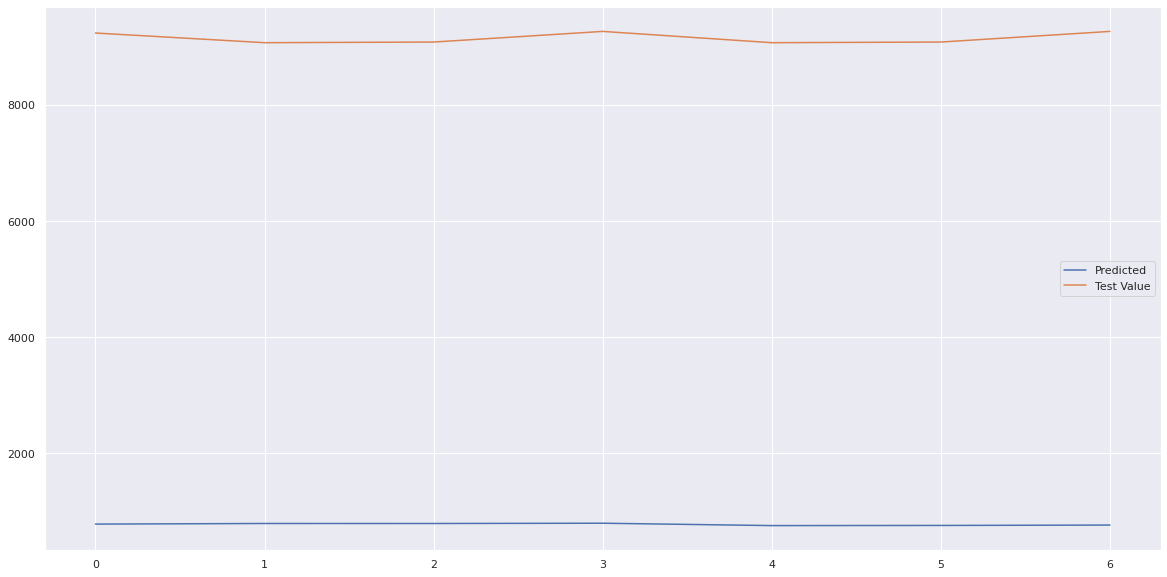

In [ ]:
# Plot the predictions against the real
plt.plot(yhat_multistep.index, yhat_multistep[0], label='Predicted')
plt.plot(y_test.index, y_test[0],label='Test Value')
plt.legend()
plt.show()


In [ ]:
# y_test = scaler.inverse_transform(y_test)
# y_test = pd.DataFrame(y_test)


In [ ]:
# y_test.columns = ['BTC_test', 'ETHER_test','XRP_test' ]
# y_test

,BTC_test,ETHER_test,XRP_test
0,8822.800000,211.696371,0.21783
1,8982.300000,214.120000,0.22392
2,8899.800000,209.910000,0.21926
3,8865.800000,206.730000,0.21785
4,9020.100000,205.400000,0.21686
5,9152.470993,198.960000,0.21198
6,9979.600000,212.190000,0.21879


In [ ]:
#BTC11053.772562	ETHER371.870000	 XRP0.28764

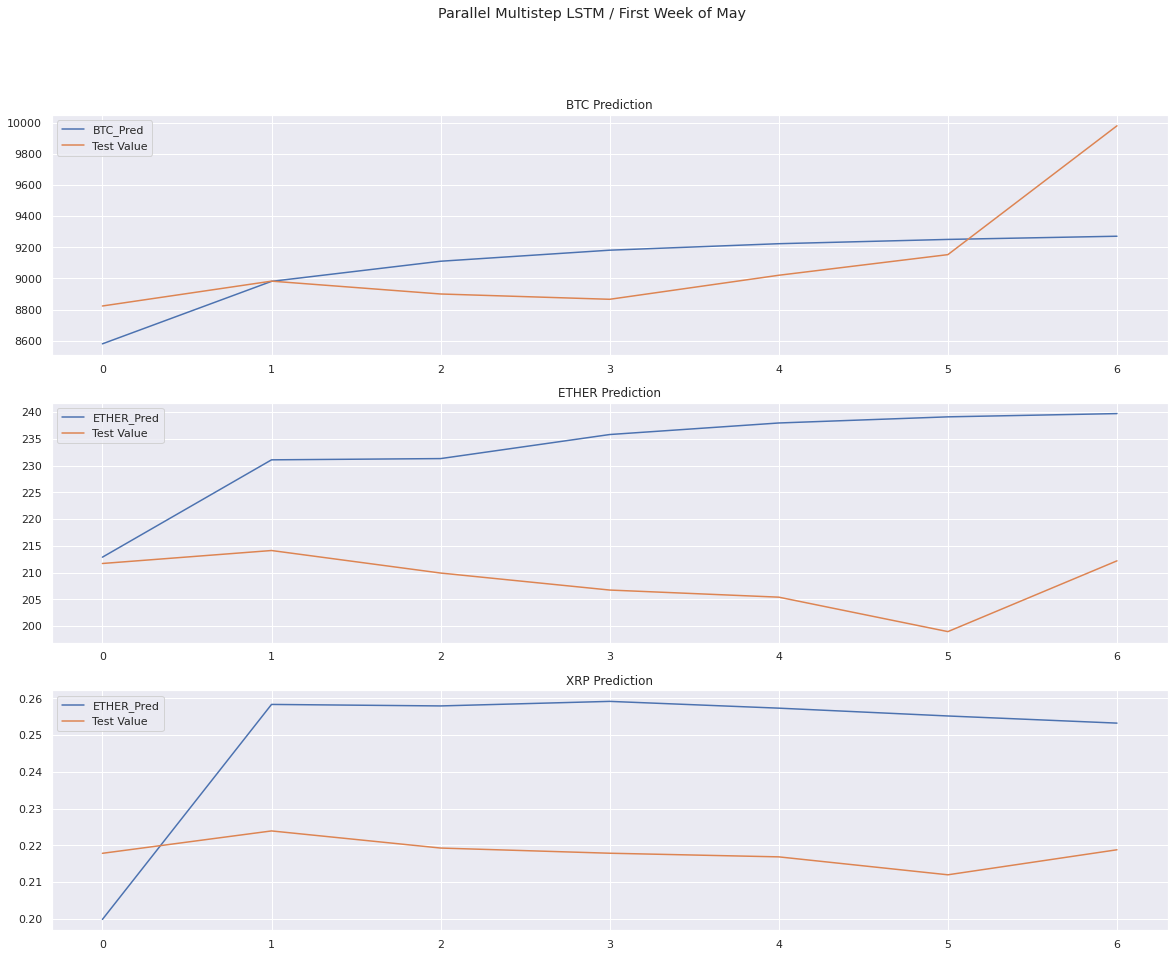

In [ ]:

fig, axs = plt.subplots(3, 1, figsize=(20,15))
plt.suptitle("Parallel Multistep LSTM / First Week of May")

axs[0].plot(yhat_parallel.index, yhat_parallel.BTC_predictions ,label='BTC_Pred')
axs[0].plot(y_test.index, y_test.BTC_test ,label='Test Value') #
axs[0].set_title('BTC Prediction')
axs[0].legend()

axs[1].plot(yhat_parallel.index,  yhat_parallel.ETHER_predictions,label='ETHER_Pred')
axs[1].plot(y_test.index, y_test.ETHER_test ,label='Test Value') 
axs[1].set_title('ETHER Prediction')
axs[1].legend()

axs[2].plot(yhat_parallel.index,  yhat_parallel.XRP_predictions,label='ETHER_Pred')
axs[2].plot(y_test.index, y_test.XRP_test ,label='Test Value') 
axs[2].set_title('XRP Prediction')
axs[2].legend()


plt.legend()
plt.show()

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val_btc = rmse(yhat_parallel.BTC_predictions, y_test.BTC_test)

rmse_val_eth = rmse(yhat_parallel.ETHER_predictions, y_test.ETHER_test)

rmse_val_xrp = rmse(yhat_parallel.XRP_predictions, y_test.XRP_test)


print(rmse_val_btc)

print(rmse_val_eth)

print(rmse_val_xrp)

# Out of Sample Predictions


## Data Set Preprocessing (Univariate)

## Data Sets

### Pred 21 to 27 Sept

In [89]:
df_21_27_url="https://raw.githubusercontent.com/DonaldTurton/iLab2/master/combined_21.9.2020.csv"
df_21_27 = pd.read_csv (df_21_27_url)
df_21_27.drop(df_21_27.tail(7).index,inplace=True) # drop last n rows
df_21_27 = df_21_27.tail(14) #Number of 
df_21_27.index = np.arange(len(df_21_27)) #restart index in 0
df_21_27


,time,BTC_open,BTC_close,BTC_vol,ETH_open,ETH_close,ETH_vol,XRP_open,XRP_close,XRP_vol
0,2020-09-07,10275.96760,10397.00000,6301.951492,353.520000,354.340000,111294.05600,0.24025,0.24277,1.220923e+07
1,2020-09-08,10400.00000,10148.00000,6761.138356,354.340000,338.000000,100546.20230,0.24284,0.23715,7.662309e+06
2,2020-09-09,10150.00000,10240.00000,2406.142398,338.000000,351.400000,65337.98496,0.23721,0.23952,8.054930e+06
3,2020-09-10,10241.00000,10355.00000,3553.975178,351.600000,368.389625,96987.67628,0.23954,0.24343,7.018266e+06
4,2020-09-11,10354.00000,10405.00000,2468.479162,368.380000,374.190000,76639.01106,0.24347,0.24284,5.171726e+06
5,2020-09-12,10404.94752,10458.00000,1434.152948,374.140000,388.100000,59788.83857,0.24284,0.24770,5.198920e+06
6,2020-09-13,10459.00000,10331.00000,4044.985627,388.100000,366.250000,79190.15293,0.24780,0.24218,1.150726e+07
7,2020-09-14,10331.00000,10690.00000,3687.510515,366.240814,377.430000,73482.01300,0.24220,0.24600,5.410656e+06
8,2020-09-15,10689.93208,10797.00000,4990.209477,377.430000,364.460000,47635.47237,0.24589,0.24345,4.901337e+06
9,2020-09-16,10797.99362,10971.25116,4798.734277,364.403379,365.690000,54745.55726,0.24336,0.24735,7.803429e+06


### Pred 5 to 11 Oct

In [129]:
df_5_11_url = "https://raw.githubusercontent.com/DonaldTurton/iLab2/master/combined%206.10.2020.csv"
df_5_11 = pd.read_csv (df_5_11_url)
df_5_11.drop(df_5_11.tail(7).index,inplace=True) # drop last n rows
df_5_11 = df_5_11.tail(14) #Number of 
df_5_11.index = np.arange(len(df_5_11)) #restart index in 0
df_5_11

,Date,BTC_open,BTC_close,BTC_vol,ETH_open,ETH_close,ETH_vol,XRP_open,XRP_close,XRP_vol
0,21/09/2020,10935.00000,10435.00000,6007.048138,371.620000,340.780000,152556.17640,0.24707,0.23122,1.557009e+07
1,22/09/2020,10435.00000,10549.00000,2412.648095,341.000000,344.650000,51867.72054,0.23148,0.23366,7.909471e+06
2,23/09/2020,10549.62173,10263.00000,3091.683241,344.720000,321.260000,112476.69120,0.23339,0.22194,8.256038e+06
3,24/09/2020,10266.00000,10754.00000,3195.717077,321.370073,349.500000,130525.59310,0.22196,0.23301,6.008354e+06
4,25/09/2020,10752.00000,10708.00000,2351.325053,349.470000,352.650000,64551.51621,0.23341,0.24175,9.489213e+06
5,26/09/2020,10708.00000,10750.00000,934.164564,352.615655,354.629363,34482.32537,0.24214,0.24202,5.133536e+06
6,27/09/2020,10750.90937,10803.00000,1754.435409,354.912100,358.460000,55477.29667,0.24210,0.24395,4.416726e+06
7,28/09/2020,10804.00000,10714.00000,3793.447098,358.560000,354.550000,56621.71373,0.24400,0.24151,6.848282e+06
8,29/09/2020,10713.00000,10856.00000,1792.598111,354.549382,360.610000,25065.79285,0.24136,0.24340,5.415805e+06
9,30/09/2020,10857.00000,10795.00000,1503.052528,360.669982,360.280000,20294.82360,0.24308,0.24216,3.320550e+06


### Pred 19 to 25 Oct

In [149]:
df_19_25_url = "https://raw.githubusercontent.com/DonaldTurton/iLab2/master/combined_19_oct.csv"
df_19_25 = pd.read_csv (df_19_25_url)
df_19_25.drop(df_19_25.tail(7).index,inplace=True) # drop last n rows
df_19_25 = df_19_25.tail(14) #Number of 
df_19_25.index = np.arange(len(df_19_25)) #restart index in 0
df_19_25

,Unnamed: 0,BTC_open,BTC_close,BTC_vol,ETH_open,ETH_close,ETH_vol,XRP_open,XRP_close,XRP_vol
0,5/10/2020,10687.00000,10807.0,1781.825965,352.970000,354.230000,20525.72169,0.24844,0.25088,1.062045e+07
1,6/10/2020,10807.00000,10613.0,3217.882601,354.260000,341.090000,48421.00701,0.25100,0.24577,2.036633e+07
2,7/10/2020,10613.00000,10687.0,1663.592872,341.085816,342.349275,52375.35982,0.24547,0.24909,8.088309e+06
3,8/10/2020,10687.32292,10943.0,3639.886113,342.310000,351.500000,65223.28601,0.24910,0.25182,8.374556e+06
4,9/10/2020,10942.90198,11071.0,2569.515021,351.734788,365.700000,39256.92188,0.25196,0.25347,6.791776e+06
5,10/10/2020,11071.00000,11308.0,4168.685885,365.710000,371.170000,37603.00581,0.25338,0.25417,1.079571e+07
6,11/10/2020,11308.00000,11385.0,1477.494261,371.150000,374.500000,17455.22858,0.25419,0.25565,4.674484e+06
7,12/10/2020,11384.00000,11560.0,6365.472410,374.650000,387.573825,78905.10692,0.25557,0.25668,6.988592e+06
8,13/10/2020,11560.00000,11442.0,3905.208567,387.390000,381.770000,37394.13037,0.25668,0.25706,1.132997e+07
9,14/10/2020,11442.72554,11440.0,2693.056076,381.740000,379.409364,37750.60262,0.25698,0.24944,2.320795e+07


### Pred 26 Oct to 1 Nov

In [241]:
df_20_10_url = "https://raw.githubusercontent.com/DonaldTurton/iLab2/master/Combined_29_10_2020.csv"
df_20_10 = pd.read_csv (df_20_10_url)
df_20_10

,Date,BTC_close,BTC_vol,ETH_close,ETH_vol,XRP_close,XRP_vol
0,2020-10-01T00:00:00Z,10634.00000,5680.680425,353.480000,62650.90834,0.23860,7.244993e+06
1,2020-10-02T00:00:00Z,10586.00000,3730.275453,346.030000,87046.01964,0.23433,8.896780e+06
2,2020-10-03T00:00:00Z,10558.58698,833.954367,346.510000,20342.13596,0.23311,2.349842e+06
3,2020-10-04T00:00:00Z,10687.00000,1626.355357,352.960000,25037.40922,0.24833,1.183465e+07
4,2020-10-05T00:00:00Z,10807.00000,1781.825965,354.230000,20525.72169,0.25088,1.062045e+07
5,2020-10-06T00:00:00Z,10613.00000,3217.882601,341.090000,48421.00701,0.24577,2.036633e+07
6,2020-10-07T00:00:00Z,10687.00000,1663.592872,342.349275,52375.35982,0.24909,8.088309e+06
7,2020-10-08T00:00:00Z,10943.00000,3639.886113,351.500000,65223.28601,0.25182,8.374556e+06
8,2020-10-09T00:00:00Z,11071.00000,2570.068023,365.700000,39256.92188,0.25347,6.791776e+06
9,2020-10-10T00:00:00Z,11308.00000,4163.351054,371.170000,37603.00581,0.25417,1.079571e+07


In [242]:
df_20_10 = df_20_10.tail(14) #Number of 
df_20_10.index = np.arange(len(df_20_10)) #restart index in 0
df_20_10

,Date,BTC_close,BTC_vol,ETH_close,ETH_vol,XRP_close,XRP_vol
0,2020-10-12T00:00:00Z,11560.00000,6368.145621,387.573825,78905.10692,0.25668,6.988592e+06
1,2020-10-13T00:00:00Z,11442.00000,3902.756184,381.770000,37522.67710,0.25706,1.136511e+07
2,2020-10-14T00:00:00Z,11440.00000,2693.056076,379.409364,37750.60262,0.24944,2.320795e+07
3,2020-10-15T00:00:00Z,11509.00000,4256.644426,377.960000,33549.12792,0.24623,1.649350e+07
4,2020-10-16T00:00:00Z,11325.00000,3461.921935,365.750000,59268.25820,0.24024,9.956805e+06
5,2020-10-17T00:00:00Z,11375.00000,1037.693503,368.770000,23536.24068,0.24069,2.909098e+06
6,2020-10-18T00:00:00Z,11518.00000,1321.880451,378.740000,30160.78345,0.24259,3.031509e+06
7,2020-10-19T00:00:00Z,11757.00000,3767.816408,379.630000,35174.16444,0.24588,4.771425e+06
8,2020-10-20T00:00:00Z,11925.00000,5422.993223,368.800000,59090.13266,0.24351,6.118180e+06
9,2020-10-21T00:00:00Z,12810.00000,15400.966260,391.370000,133501.21340,0.25154,1.016095e+07


## Univariate BTC

In [243]:
pred_BTC_df = list(df_20_10.BTC_close)
pred_BTC_df

[11560.0,
 11442.0,
 11440.0,
 11509.0,
 11325.0,
 11375.0,
 11518.0,
 11757.0,
 11925.0,
 12810.0,
 12988.0,
 12935.0,
 13127.03664,
 13037.0]

In [244]:
pred_BTC_df.extend([0, 0, 0, 0, 0, 0, 0]) # Add 7 values to comply with the shape 
print(pred_BTC_df)

[11560.0, 11442.0, 11440.0, 11509.0, 11325.0, 11375.0, 11518.0, 11757.0, 11925.0, 12810.0, 12988.0, 12935.0, 13127.03664, 13037.0, 0, 0, 0, 0, 0, 0, 0]


In [245]:
# define input sequence for TEST
pred_seq = pred_BTC_df
# choose a number of time steps
n_steps_in, n_steps_out = 14, 7
# split into samples
X_pred, y_pred = split_sequence(pred_seq, n_steps_in, n_steps_out)

In [246]:
#Reshape
n_features = 1

X_pred = X_pred.reshape((X_pred.shape[0], X_pred.shape[1], n_features))

#inspect shapes 
print(X_pred.shape)

(1, 14, 1)


In [247]:
X_pred

array([[[11560.     ],
        [11442.     ],
        [11440.     ],
        [11509.     ],
        [11325.     ],
        [11375.     ],
        [11518.     ],
        [11757.     ],
        [11925.     ],
        [12810.     ],
        [12988.     ],
        [12935.     ],
        [13127.03664],
        [13037.     ]]])

In [248]:
y_pred

array([[0, 0, 0, 0, 0, 0, 0]])

## Stacked LSTM Prediction



In [249]:
# Create the predictions data frame
ypred_stacked = pd.DataFrame(np.reshape(np.array(stacked_LSTM.predict(X_pred, verbose=0)), (7,1))) 

ypred_stacked.columns = ['predictions']

In [250]:
ypred_stacked

,predictions
0,12957.972656
1,12828.689453
2,12852.964844
3,12791.413086
4,12852.940430
5,12880.587891
6,12803.291016


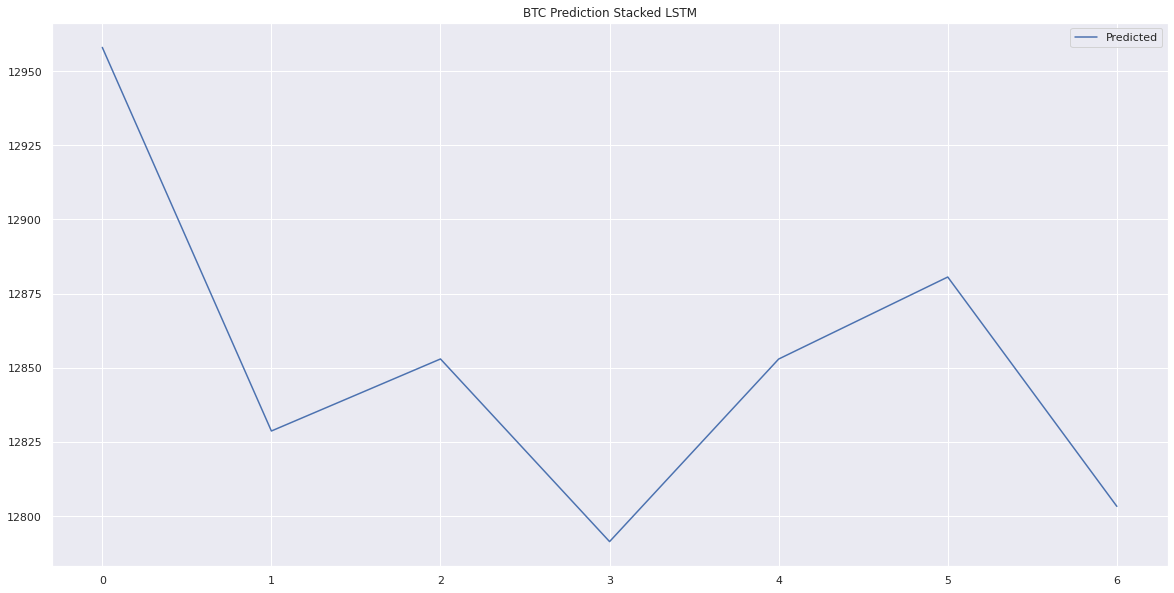

In [251]:
# Plot the predictions against the truth
plt.plot(ypred_stacked.index, ypred_stacked.predictions, label='Predicted')
plt.title("BTC Prediction Stacked LSTM")
plt.legend()
plt.show()

## Encoder Decoder

In [252]:
ED_LSTM

In [253]:
# Create the predictions data frame
ypred_ED= pd.DataFrame(np.reshape(np.array(ED_LSTM.predict(X_pred, verbose=0)), (7,1))) 

ypred_ED.columns = ['predictions']

In [254]:
ypred_ED

,predictions
0,13024.132812
1,13031.778320
2,13018.343750
3,13002.324219
4,13006.461914
5,13005.393555
6,13005.666992


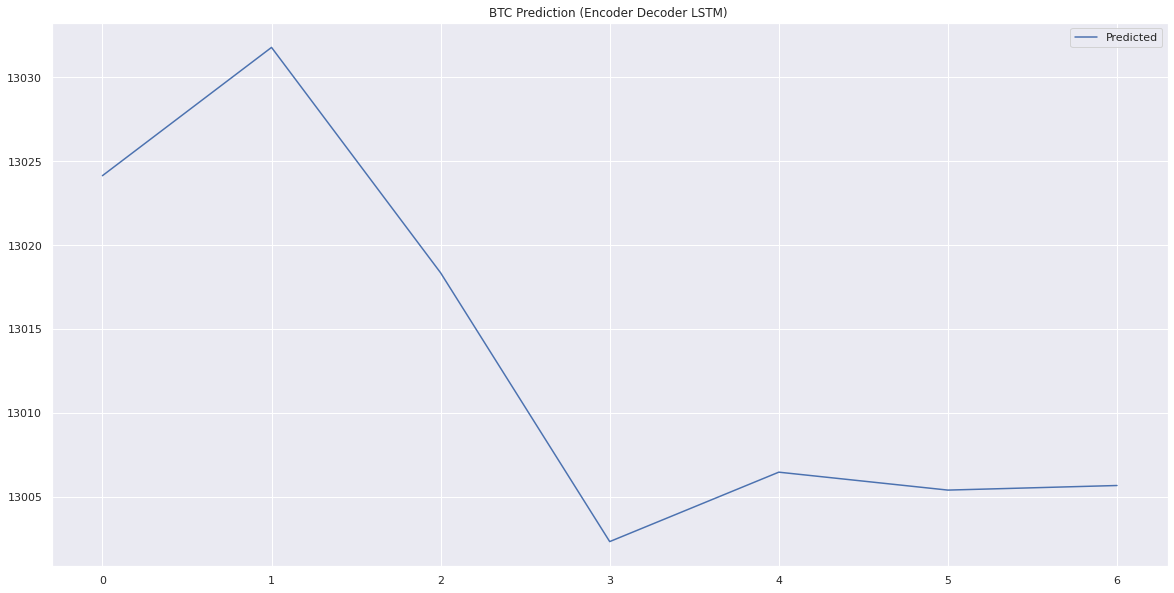

In [255]:
# Plot the predictions against the truth
plt.plot(ypred_ED.index, ypred_ED.predictions, label='Predicted')
plt.title("BTC Prediction (Encoder Decoder LSTM) ")
plt.legend()
plt.show()

## CNN LSTM Predictions

In [256]:
n_features = 1
n_seq = 2    #2 Subsambples
n_steps = 7  # 2 subsamples of 7 steps 

In [257]:
#Get X test into the right shape
X_pred_CNN = X_pred.reshape((1, n_seq, n_steps, n_features))

#Predidt
ypred_CNN_LSTM = CNN_LSTM.predict(X_pred_CNN, verbose=0)

In [258]:
#Tranform the predictions into a Df
ypred_CNN_LSTM = pd.DataFrame(ypred_CNN_LSTM)

In [259]:
#Reshape the DF 
ypred_CNN_LSTM = ypred_CNN_LSTM.T
ypred_CNN_LSTM.columns = ['predictions']

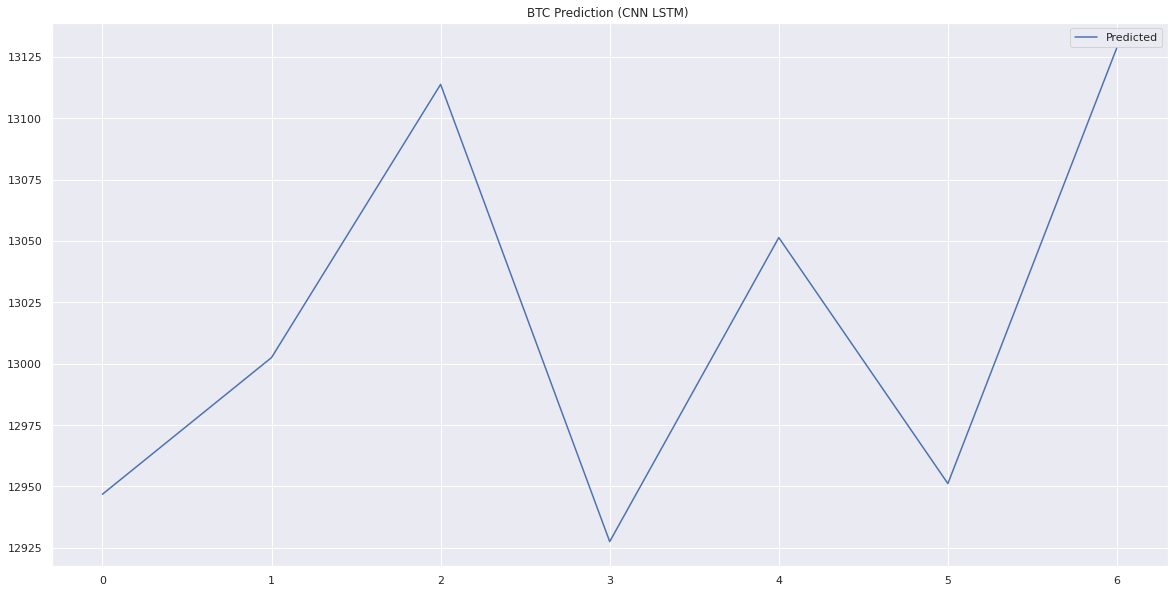

In [260]:
# Plot the predictions against the truth

plt.plot(ypred_CNN_LSTM.index, ypred_CNN_LSTM.predictions, label='Predicted')
plt.title("BTC Prediction (CNN LSTM) ")
plt.legend()
plt.show()

## Univariate LSTM Predictions 

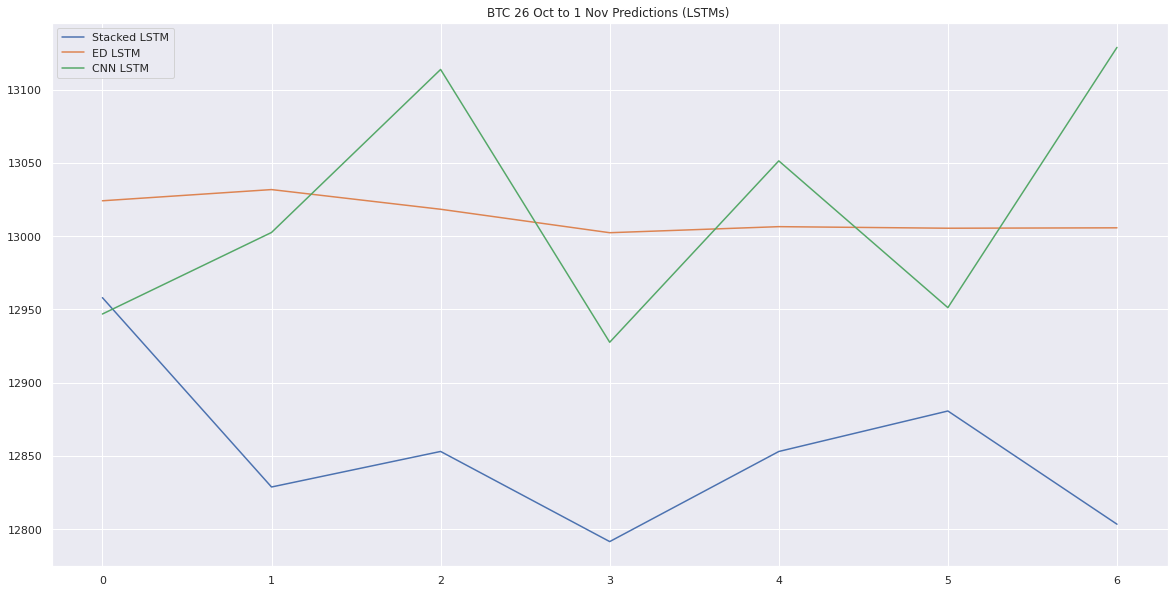

In [263]:
plt.plot(ypred_stacked.index, ypred_stacked.predictions, label='Stacked LSTM')
plt.plot(ypred_ED.index, ypred_ED.predictions, label='ED LSTM')
plt.plot(ypred_CNN_LSTM.index, ypred_CNN_LSTM.predictions, label='CNN LSTM')
plt.title("BTC 26 Oct to 1 Nov Predictions (LSTMs) ")
plt.legend()
plt.show()

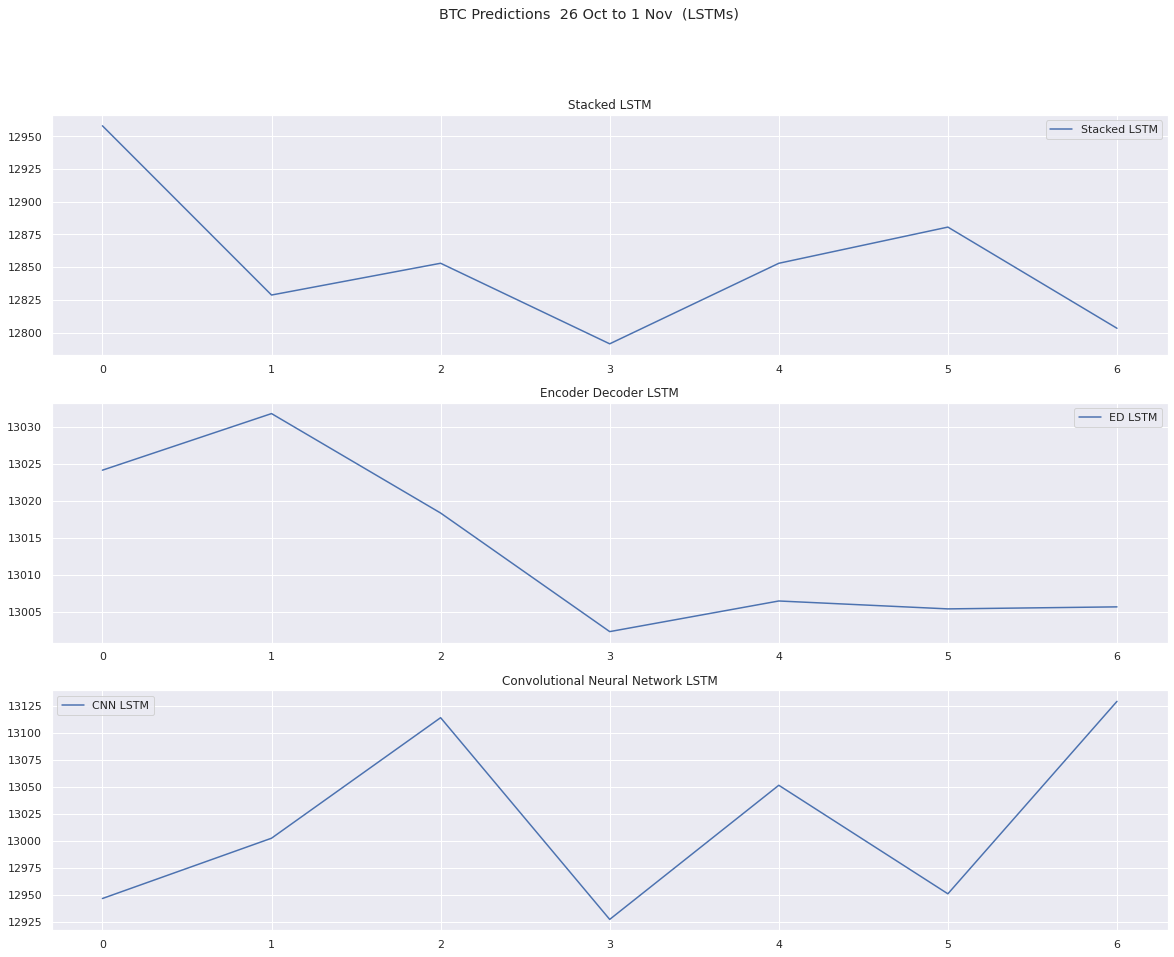

In [265]:
# Another way to present them
fig, axs = plt.subplots(3, 1, figsize=(20,15))
plt.suptitle("BTC Predictions  26 Oct to 1 Nov  (LSTMs) ")

axs[0].plot(ypred_stacked.index, ypred_stacked.predictions, label='Stacked LSTM')
axs[0].set_title('Stacked LSTM')
axs[0].legend()

axs[1].plot(ypred_ED.index, ypred_ED.predictions, label='ED LSTM')
axs[1].set_title('Encoder Decoder LSTM')
axs[1].legend()

axs[2].plot(ypred_CNN_LSTM.index, ypred_CNN_LSTM.predictions, label='CNN LSTM')
axs[2].set_title('Convolutional Neural Network LSTM')
axs[2].legend()


plt.legend()
plt.show()

## Data Set Preprocessing (Multivariate)

In [276]:
df_5_11

,Date,BTC_open,BTC_close,BTC_vol,ETH_open,ETH_close,ETH_vol,XRP_open,XRP_close,XRP_vol
0,21/09/2020,10935.00000,10435.00000,6007.048138,371.620000,340.780000,152556.17640,0.24707,0.23122,1.557009e+07
1,22/09/2020,10435.00000,10549.00000,2412.648095,341.000000,344.650000,51867.72054,0.23148,0.23366,7.909471e+06
2,23/09/2020,10549.62173,10263.00000,3091.683241,344.720000,321.260000,112476.69120,0.23339,0.22194,8.256038e+06
3,24/09/2020,10266.00000,10754.00000,3195.717077,321.370073,349.500000,130525.59310,0.22196,0.23301,6.008354e+06
4,25/09/2020,10752.00000,10708.00000,2351.325053,349.470000,352.650000,64551.51621,0.23341,0.24175,9.489213e+06
5,26/09/2020,10708.00000,10750.00000,934.164564,352.615655,354.629363,34482.32537,0.24214,0.24202,5.133536e+06
6,27/09/2020,10750.90937,10803.00000,1754.435409,354.912100,358.460000,55477.29667,0.24210,0.24395,4.416726e+06
7,28/09/2020,10804.00000,10714.00000,3793.447098,358.560000,354.550000,56621.71373,0.24400,0.24151,6.848282e+06
8,29/09/2020,10713.00000,10856.00000,1792.598111,354.549382,360.610000,25065.79285,0.24136,0.24340,5.415805e+06
9,30/09/2020,10857.00000,10795.00000,1503.052528,360.669982,360.280000,20294.82360,0.24308,0.24216,3.320550e+06


In [277]:
df_20_10_Multi = df_5_11[["BTC_close","ETH_close", "XRP_close" ]]
df_20_10_Multi

,BTC_close,ETH_close,XRP_close
0,10435.00000,340.780000,0.23122
1,10549.00000,344.650000,0.23366
2,10263.00000,321.260000,0.22194
3,10754.00000,349.500000,0.23301
4,10708.00000,352.650000,0.24175
5,10750.00000,354.629363,0.24202
6,10803.00000,358.460000,0.24395
7,10714.00000,354.550000,0.24151
8,10856.00000,360.610000,0.24340
9,10795.00000,360.280000,0.24216


In [278]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler(feature_range=(-1,1))

#scaler = StandardScaler()

df_20_10_Multi = scaler.fit_transform(df_20_10_Multi)
df_20_10_Multi = pd.DataFrame(df_20_10_Multi)
df_20_10_Multi.columns = ['BTC_close','ETHER_close', 'XRP_close']
df_20_10_Multi

,BTC_close,ETHER_close,XRP_close
0,-0.419899,-0.007878,-0.296703
1,-0.035413,0.188818,-0.111785
2,-1.000000,-1.000000,-1.000000
3,0.655987,0.435324,-0.161046
4,0.500843,0.595426,0.501326
5,0.642496,0.696029,0.521789
6,0.821248,0.890724,0.668056
7,0.521079,0.691995,0.483138
8,1.000000,1.000000,0.626374
9,0.794266,0.983227,0.532399


In [279]:
#Check the sacle for values 
print("Min:", np.min(df_20_10_Multi))
print("Max:", np.max(df_20_10_Multi))

Min: BTC_close     -1.0
ETHER_close   -1.0
XRP_close     -1.0
dtype: float64
Max: BTC_close      1.0
ETHER_close    1.0
XRP_close      1.0
dtype: float64


In [280]:
extra_space = [{'BTC_close':0 ,'ETHER_close': 0,'XRP_close':0} ,
         {'BTC_close':0 ,'ETHER_close': 0,'XRP_close':0} ,
         {'BTC_close':0 ,'ETHER_close': 0,'XRP_close':0} ,
         {'BTC_close':0 ,'ETHER_close': 0,'XRP_close':0} ,
         {'BTC_close':0 ,'ETHER_close': 0,'XRP_close':0} ,
         {'BTC_close':0 ,'ETHER_close': 0,'XRP_close':0} ,
         {'BTC_close':0 ,'ETHER_close': 0,'XRP_close':0 }]


df_20_10_Multi = df_20_10_Multi.append(extra_space,ignore_index=True,sort=True)
df_20_10_Multi

,BTC_close,ETHER_close,XRP_close
0,-0.419899,-0.007878,-0.296703
1,-0.035413,0.188818,-0.111785
2,-1.000000,-1.000000,-1.000000
3,0.655987,0.435324,-0.161046
4,0.500843,0.595426,0.501326
5,0.642496,0.696029,0.521789
6,0.821248,0.890724,0.668056
7,0.521079,0.691995,0.483138
8,1.000000,1.000000,0.626374
9,0.794266,0.983227,0.532399


In [281]:
# Reshape Pred data 
# define input sequence
pred_in_seq1 = np.array(df_20_10_Multi.BTC_close)
pred_in_seq2 = np.array(df_20_10_Multi.ETHER_close)
pred_out_seq = np.array(df_20_10_Multi.XRP_close)


# convert to [rows, columns] structure
pred_in_seq1 = pred_in_seq1.reshape((len(pred_in_seq1), 1))
pred_in_seq2 = pred_in_seq2.reshape((len(pred_in_seq2), 1))
pred_out_seq = pred_out_seq.reshape((len(pred_out_seq), 1))


from numpy import hstack
# horizontally stack columns
pred_dataset = hstack((pred_in_seq1, pred_in_seq2, pred_out_seq))

# choose a number of time steps
n_steps_in, n_steps_out = 14,7 #14, 14
# covert into input/output
X_pred, y_pred = split_sequences(pred_dataset, n_steps_in, n_steps_out)

print(X_pred.shape, y_pred.shape)
#number of samples, time steps, and variables

(1, 14, 3) (1, 7, 3)


In [282]:
X_pred

array([[[-0.41989882, -0.00787802, -0.2967033 ],
        [-0.03541315,  0.1888183 , -0.11178477],
        [-1.        , -1.        , -1.        ],
        [ 0.65598651,  0.43532402, -0.16104585],
        [ 0.50084317,  0.59542567,  0.50132626],
        [ 0.64249578,  0.69602864,  0.52178856],
        [ 0.82124789,  0.89072427,  0.66805608],
        [ 0.52107926,  0.69199492,  0.48313755],
        [ 1.        ,  1.        ,  0.62637363],
        [ 0.79426644,  0.98322745,  0.53239864],
        [ 0.25126476,  0.63761118,  0.26259947],
        [ 0.08937605,  0.25895807, -0.06100796],
        [-0.00307933,  0.28335451, -0.15346722],
        [ 0.43001686,  0.6111817 ,  1.        ]]])

In [283]:
y_pred


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [284]:
# Create the predictions data frame
n_features = 3
pred_parallel = pd.DataFrame(np.reshape(np.array(Paralell_ED.predict(X_pred, verbose=0)), (n_steps_out,n_features)))

In [285]:
pred_parallel

,0,1,2
0,0.373040,0.567791,0.327308
1,0.331351,0.611563,0.294135
2,0.310341,0.642781,0.251346
3,0.283681,0.643954,0.194246
4,0.264713,0.641160,0.150444
5,0.251014,0.636272,0.120252
6,0.242544,0.632112,0.101904


In [286]:
pred_parallel = scaler.inverse_transform(pred_parallel)
pred_parallel = pd.DataFrame(pred_parallel)

In [287]:
pred_parallel.columns = ['BTC_predictions', 'ETHER_predictions', 'XRP_predictions']
pred_parallel

,BTC_predictions,ETHER_predictions,XRP_predictions
0,10670.105469,352.106262,0.239454
1,10657.745117,352.967529,0.239016
2,10651.515625,353.581726,0.238452
3,10643.612305,353.604767,0.237698
4,10637.987305,353.549835,0.237120
5,10633.925781,353.453644,0.236722
6,10631.414062,353.371796,0.236480


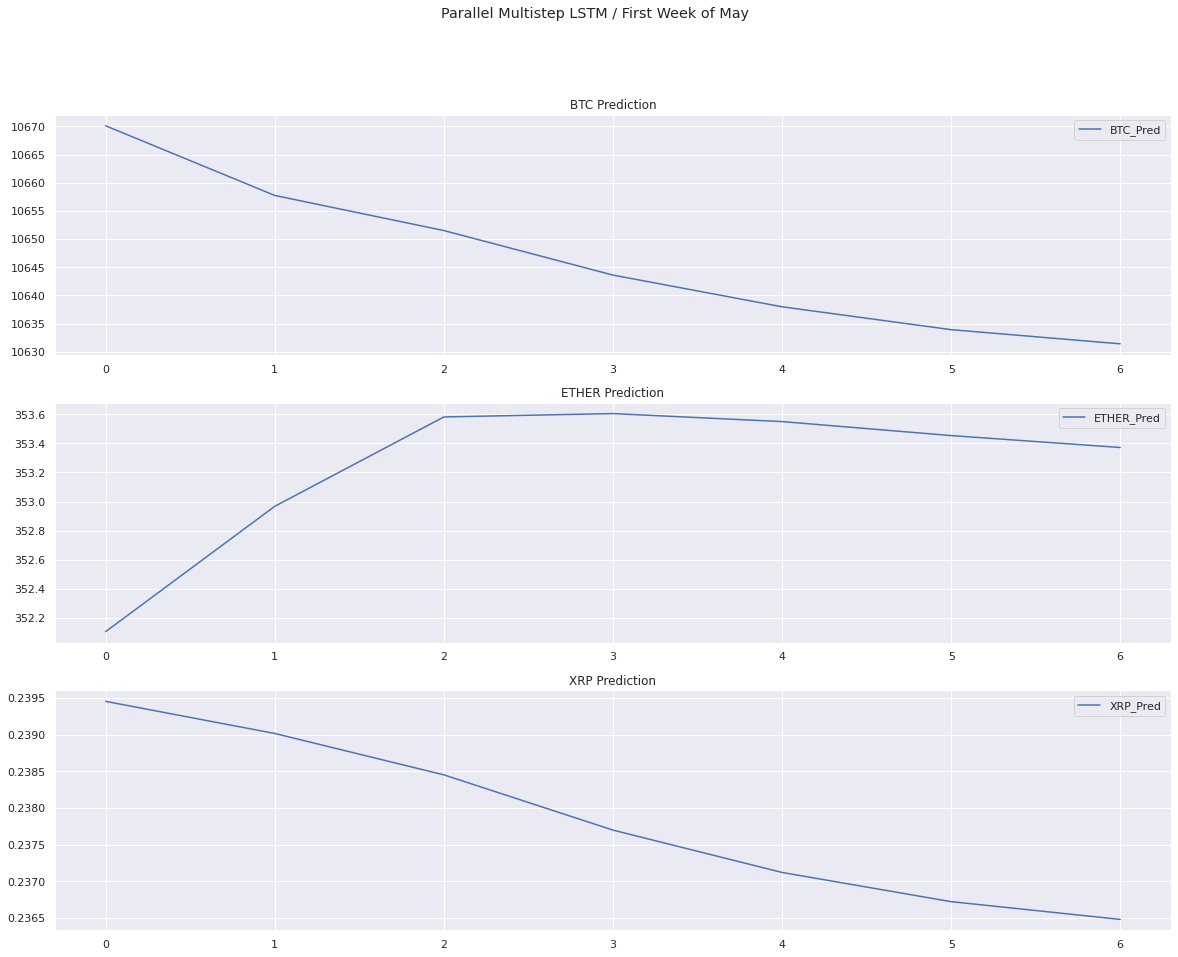

In [288]:

fig, axs = plt.subplots(3, 1, figsize=(20,15))
plt.suptitle("Parallel Multistep LSTM / First Week of May")

axs[0].plot(pred_parallel.index, pred_parallel.BTC_predictions ,label='BTC_Pred')
axs[0].set_title('BTC Prediction')
axs[0].legend()

axs[1].plot(pred_parallel.index,  pred_parallel.ETHER_predictions,label='ETHER_Pred')
axs[1].set_title('ETHER Prediction')
axs[1].legend()

axs[2].plot(pred_parallel.index,  pred_parallel.XRP_predictions,label='XRP_Pred')
axs[2].set_title('XRP Prediction')
axs[2].legend()


plt.legend()
plt.show()

## ALL MODELS PRED

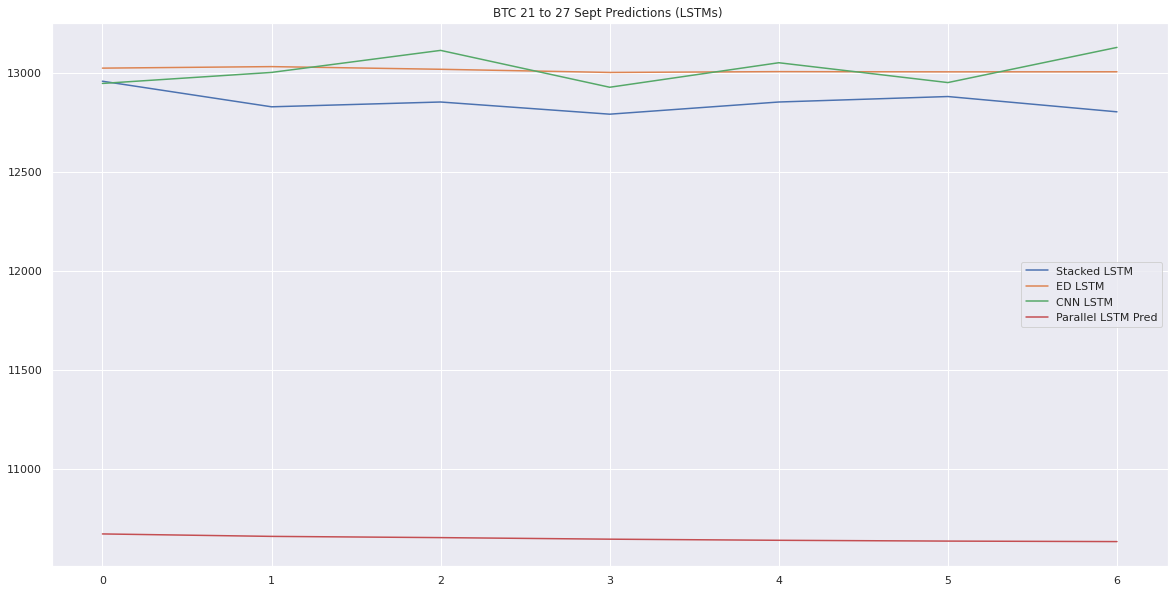

In [289]:
plt.plot(ypred_stacked.index, ypred_stacked.predictions, label='Stacked LSTM')
plt.plot(ypred_ED.index, ypred_ED.predictions, label='ED LSTM')
plt.plot(ypred_CNN_LSTM.index, ypred_CNN_LSTM.predictions, label='CNN LSTM')
plt.plot(pred_parallel.index, pred_parallel.BTC_predictions ,label='Parallel LSTM Pred')
plt.title("BTC 21 to 27 Sept Predictions (LSTMs) ")
plt.legend()
plt.show()